# Loading libraries and dataframe with added locations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn as sk

In [2]:
df=pd.read_csv('combined_data_with_loc.csv')
df.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


In [3]:
print(df['Community Name'])

0            Ascot Vale
1             Braybrook
2           Craigieburn
3               Croydon
4               Fawkner
5             Footscray
6               Glenroy
7          Malvern East
8               Malvern
9     Melbourne Airport
10              Mentone
11            Moorabbin
12           Mordialloc
13          Murrumbeena
14           Noble Park
15      North Melbourne
16            Northcote
17            Parkville
18    Pascoe Vale South
19       Port Melbourne
20              Prahran
21           Somerville
22             Sorrento
23      South Melbourne
24          South Yarra
25           Springvale
26     St Andrews Beach
27        St Kilda East
28             St Kilda
29        St Kilda West
30               Toorak
31                Tyabb
32            Waterways
33              Windsor
Name: Community Name, dtype: object


Formatting locational data for downstream tasks

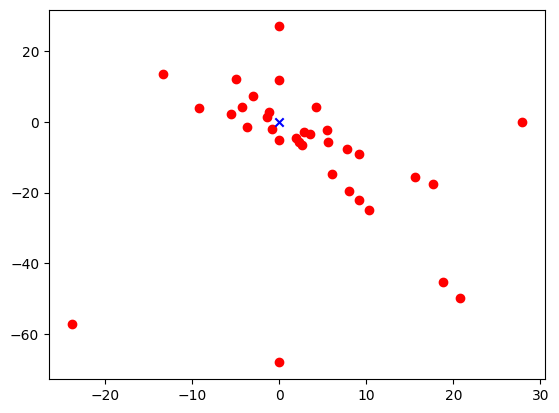

In [4]:
locs=np.asarray(list(zip(df['cart_x'],df['cart_y'])))

# plot locs on a scatter plot, with (0,0) at the center
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(0,0,color='blue', marker='x')
plt.show()


# Beginning The Clustering Process

## Reasoning

Before addressing the hypothesis of "Nearby Suburbs are Similar", we first need to set up clusters of *_nearby_* suburbs. Afterwards, we'll address if the within-cluster locations are similar in nature using the metrics that we'll be defining afterwards.

The reasoning behind this approach is: 

We should not let the similarity metrics derived from the features influence the city-clustering, consciously or subconsciouly. We decide upon what qualifies as the close-by suburbs first, only then we judge upon the goodness of our hypothesis by our defined measures.

## Handling Locationally Outlier Suburbs

We'll decide the 'outliers' in two ways:
1. How far away they are from the origin (Melbourne GPO)
2. How isolated a point is in terms of pairwise distances with other points

### 1. Distance from the Origin

We'll analyse the distribution in terms of each of the co-ordinates. We'll consider the suburbs with $(x,y)$ such that

 $x \not\in (Q^x_1-1.5\times IQR_x, Q^x_3+1.5\times IQR_x)$ $\text{OR}$ $y \not\in (Q^y_1-1.5\times IQR_y, Q^y_3+1.5\times IQR_y)$.

as outliers.


DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
[-1.34419175  2.4833545   7.96892529]
[-15.37890098  -4.08438017   2.65811421]


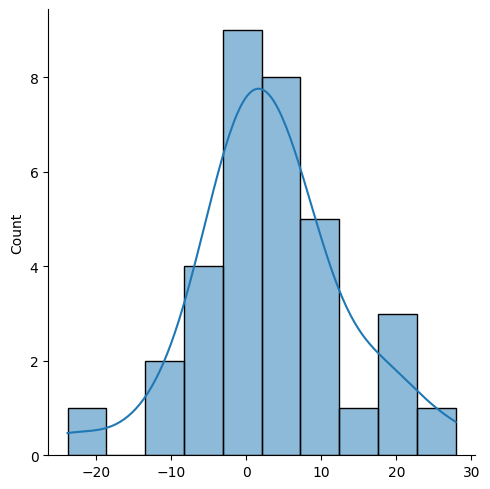

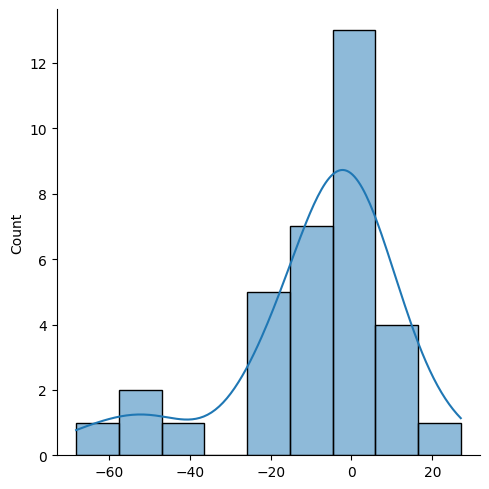

In [5]:
# describe the locational data
import scipy.stats as stats
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print(np.percentile(locs[:,0], [25, 50, 75]))
print(np.percentile(locs[:,1], [25, 50, 75]))

sns.displot(locs[:,0], kde=True)
plt.show()

sns.displot(locs[:,1], kde=True)
plt.show()




$x$ looks normally distributed, while $y$ does not. We'll test it.

In [6]:
# perform shapiro-wilk test for normality of x and y coordinates
print(stats.shapiro(locs[:,0]))
print(stats.shapiro(locs[:,1]))

# perform anderson-darling test for normality of x and y coordinates
print(stats.anderson(locs[:,0]))
print(stats.anderson(locs[:,1]))


ShapiroResult(statistic=np.float64(0.9670688954563095), pvalue=np.float64(0.3855347856075575))
ShapiroResult(statistic=np.float64(0.8707230058313595), pvalue=np.float64(0.00084308888086645))
AndersonResult(statistic=np.float64(0.5158051454446735), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.199193322824144), scale=np.float64(9.934957793182829))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=np.float64(1.7286553541403507), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-8.851619191333763), scale=np.float64(20.4022684415311))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


Both the tests confirm that $x$ is normally distributed and $y$ is not.

While this approach does not serve us too much at this point, it's good to have some idea what we'll be dealing with next.

We'll now visualize the sururbs on a scatterplot.

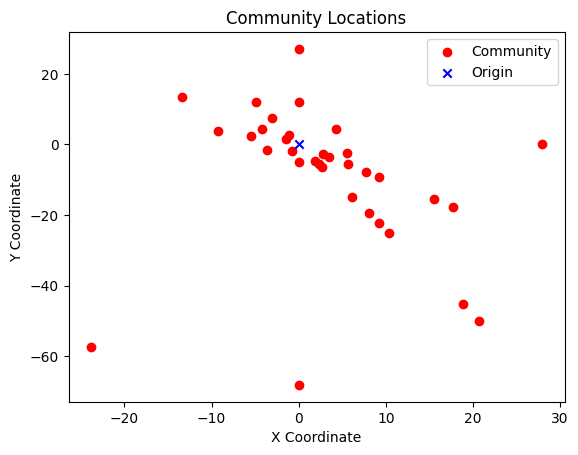

In [73]:
plt.scatter(locs[:,0],locs[:,1],color='red')
# scale the origin as well
origin = np.array([[0,0]])
# origin = scaler.transform(origin)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.legend(['Community','Origin'])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Community Locations')
plt.show()

We now figure out the quartiles and do a boxplot for the same.

DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
The x quartiles are: [-1.34419175  2.4833545   7.96892529]
The y quartiles are: [-15.37890098  -4.08438017   2.65811421]


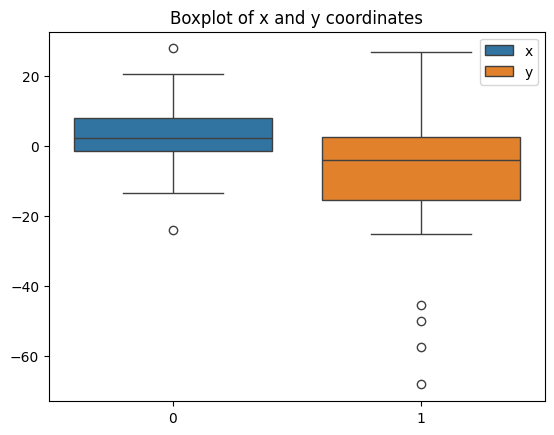

In [72]:
# Determine the distribution of the scaled data
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print('The x quartiles are:',np.percentile(locs[:,0], [25, 50, 75]))
print('The y quartiles are:',np.percentile(locs[:,1], [25, 50, 75]))

# do a boxplot of the scaled data
sns.boxplot(data=locs)
# show the legend
plt.legend(['x','y'])
plt.title('Boxplot of x and y coordinates')
plt.show()

As can be seen from the boxplot, the $y$ coordinate contains a bit more outliers as compared to $x$.

Number of outliers in x co-ordinate: 2
Number of outliers in y co-ordinate: 4
Total number of outliers (either in x or y): 5


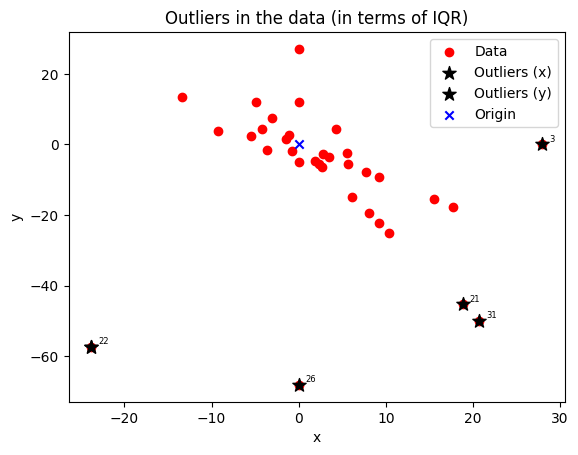

The outlier indices are: [ 3 21 22 26 31]
The corresponding community names are:
 3              Croydon
21          Somerville
22            Sorrento
26    St Andrews Beach
31               Tyabb
Name: Community Name, dtype: object


In [71]:
# count the number of 'outliers' in the scaled data in terms of IQR
# these are the far away points from the main 'mass' of the data
q1_x, q3_x = np.percentile(locs[:,0], [25, 75])
iqr_x = q3_x - q1_x
outliers_x = (locs[:,0] < q1_x - 1.5*iqr_x) | (locs[:,0] > q3_x + 1.5*iqr_x)
print('Number of outliers in x co-ordinate:',np.sum(outliers_x))

q1_y, q3_y = np.percentile(locs[:,1], [25, 75])
iqr_y = q3_y - q1_y
outliers_y = (locs[:,1] < q1_y - 1.5*iqr_y) | (locs[:,1] > q3_y + 1.5*iqr_y)
print('Number of outliers in y co-ordinate:',np.sum(outliers_y))

# count the total number of outliers
print('Total number of outliers (either in x or y):',np.sum(outliers_x | outliers_y))

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_x,0],locs[outliers_x,1],color='black', marker='*',s=100)
plt.scatter(locs[outliers_y,0],locs[outliers_y,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')

# also annotate each outlier with the corresponding index
for i in np.where(outliers_x | outliers_y)[0]:
	plt.annotate(i, (locs[i,0]+.8,locs[i,1]+.8), fontsize=6)

# show the legend
plt.legend(['Data','Outliers (x)','Outliers (y)','Origin'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers in the data (in terms of IQR)')
plt.show()

# print the outlier indices and the corresponding community names
coord_outliers = np.where(outliers_x | outliers_y)[0]
print('The outlier indices are:',coord_outliers)
print('The corresponding community names are:\n',df['Community Name'][coord_outliers])


### 2. Pairwise Distances

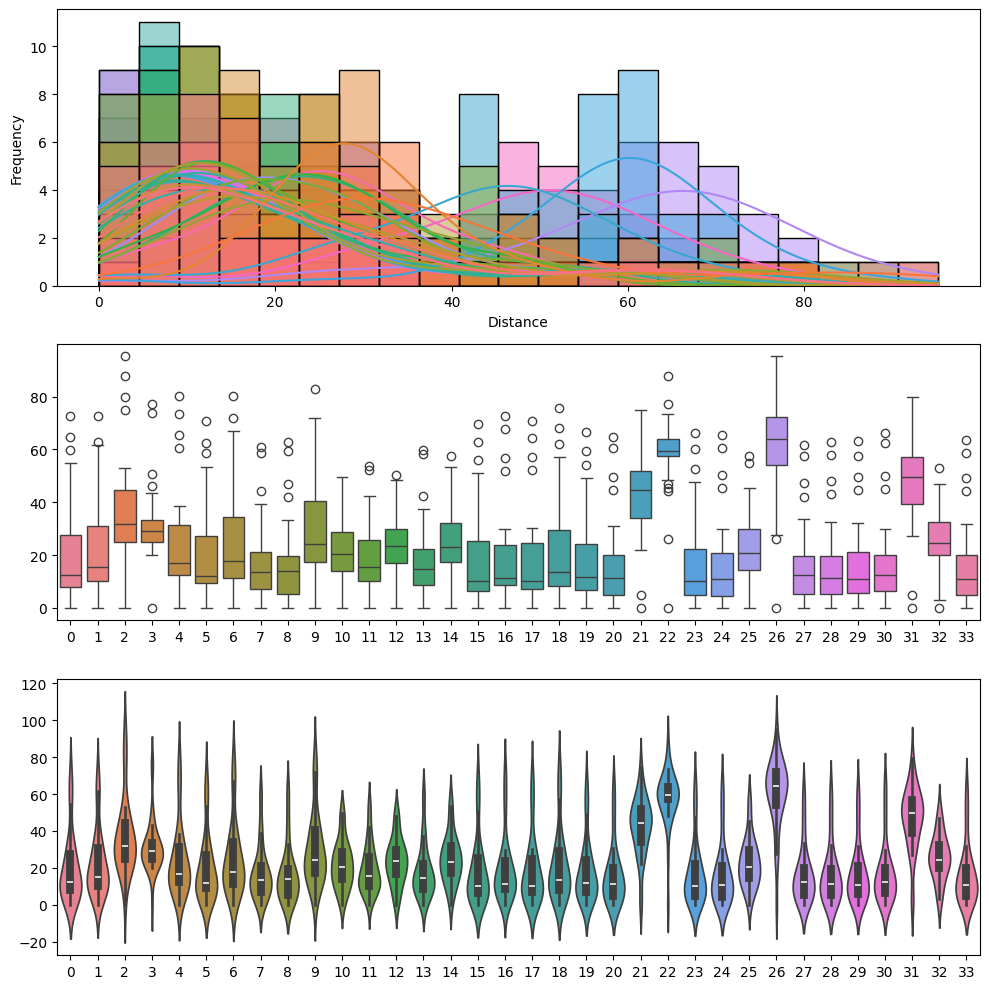

In [96]:
# However, we are yet to consider the pair-wise distances between the points
# We will now calculate the pair-wise distances between the points and analyze them
# We will use the euclidean distance for this purpose
from scipy import spatial
distances = spatial.distance.pdist(locs)
# convert the distances to a square matrix
dist_matrix = spatial.distance.squareform(distances)


# create a collection of subplots
# First row: Histogram of distances, boxplot of distances
# second row: only violin plot of distances
fig, ax = plt.subplots(3,1,figsize=(10,10))
# First row: Histogram of distances with KDE
hist_plot = sns.histplot(dist_matrix, kde=True, ax=ax[0],legend=False)
hist_plot.set(xlabel='Distance', ylabel='Frequency')
sns.boxplot(data=dist_matrix, ax=ax[1])
sns.violinplot(data=dist_matrix, ax=ax[2])
# make the legend for the first plot horizontal
plt.tight_layout()
plt.show()

In [157]:
# do a local outlier factor analysis on the distances
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=5)
lof.fit_predict(locs)
# get the negative outlier factor
lof_scores = lof.negative_outlier_factor_
# get the outlier indices
# lof_outliers = lof_scores < -1.5
# print('Number of outliers detected by LOF:',np.sum(lof_outliers))
# print('The outlier indices detected by LOF:',np.where(lof_outliers)[0])

# pick the top 5 outliers
top_lof_outliers = np.argsort(lof_scores)[:5]
print('The top 5 outliers detected by LOF:',top_lof_outliers)
print('The corresponding community names are:\n',df['Community Name'][top_lof_outliers])



The top 5 outliers detected by LOF: [ 3 22  2 31 26]
The corresponding community names are:
 3              Croydon
22            Sorrento
2          Craigieburn
31               Tyabb
26    St Andrews Beach
Name: Community Name, dtype: object


In [117]:
import pandas as pd

# Get a DataFrame from the Tukey HSD results
tukey_results = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])

# Filter the pairs where the null hypothesis was rejected and where it was not rejected
rejections = tukey_results[tukey_results['reject'] == True]
non_rejections = tukey_results[tukey_results['reject'] == False]

# Count the number of rejections each group was involved in
rejection_counts = rejections['group1'].value_counts() + rejections['group2'].value_counts()
rejection_counts = rejection_counts.sort_values(ascending=False)

# Count the number of non-rejections each group was involved in
non_rejection_counts = non_rejections['group1'].value_counts() + non_rejections['group2'].value_counts()
non_rejection_counts = non_rejection_counts.sort_values(ascending=False)

# Display the results
print("Groups with the highest number of null hypothesis rejections:")
print(rejection_counts)

print("\nGroups with the highest number of null hypothesis non-rejections:")
print(non_rejection_counts)


Groups with the highest number of null hypothesis rejections:
Community_22    21.0
Community_26    16.0
Community_2      4.0
Community_23     2.0
Community_24     2.0
Community_0      NaN
Community_1      NaN
Community_10     NaN
Community_11     NaN
Community_12     NaN
Community_13     NaN
Community_14     NaN
Community_15     NaN
Community_16     NaN
Community_17     NaN
Community_19     NaN
Community_20     NaN
Community_27     NaN
Community_28     NaN
Community_4      NaN
Community_5      NaN
Community_6      NaN
Community_7      NaN
Community_8      NaN
Name: count, dtype: float64

Groups with the highest number of null hypothesis non-rejections:
Community_18    32.0
Community_21    32.0
Community_31    32.0
Community_30    32.0
Community_29    32.0
Community_3     32.0
Community_25    32.0
Community_32    32.0
Community_4     31.0
Community_28    31.0
Community_14    31.0
Community_19    31.0
Community_6     31.0
Community_10    30.0
Community_13    30.0
Community_1     30.0
Com

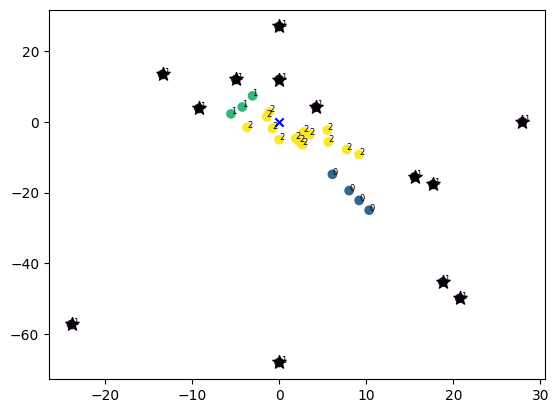

Number of clusters: 4
Number of noise points: 13


In [101]:
# Now do HDBSCAN clustering on the locational data

import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True, min_samples=1)
clusterer.fit(locs)

# plot the clusters
plt.scatter(locs[:,0],locs[:,1],c=clusterer.labels_)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
# highlight the noise points
plt.scatter(locs[clusterer.labels_==-1,0],locs[clusterer.labels_==-1,1],color='black', marker='*',s=100)
# annotate each point with the corresponding cluster label
for i in range(len(locs)):
	plt.annotate(clusterer.labels_[i], (locs[i,0],locs[i,1]), size=6)

plt.show()
print('Number of clusters:',len(np.unique(clusterer.labels_)))
print('Number of noise points:',np.sum(clusterer.labels_==-1))

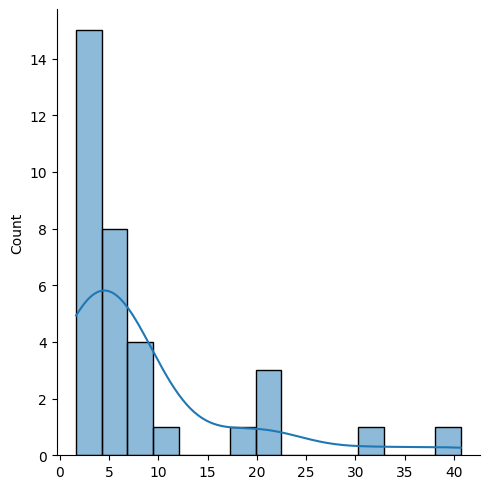

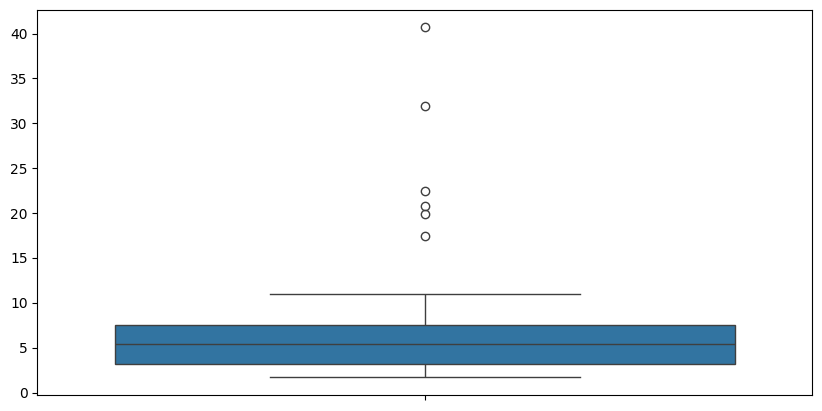

Number of outliers in terms of average distances: 6
Indices of the outliers: [ 2  3 21 22 26 31]
Threshold distance: 11.780298428558057


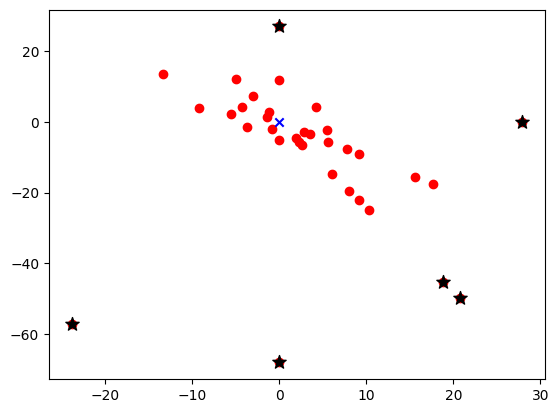

In [102]:
# Now, do the following: For each point take the top 5 nearest neighbors and calculate the average distance
# to these neighbors. Then, plot the histogram of these average distances.
# We will use the KDTree for this purpose
from scipy.spatial import KDTree
tree = KDTree(locs)
# get the 6 nearest neighbors (including the point itself)
distances, indices = tree.query(locs, k=5)
# calculate the average distance to the 5 nearest neighbors
avg_distances = np.mean(distances[:,1:], axis=1)
# plot the histogram of the average distances
sns.displot(avg_distances, kde=True)
plt.show()

# boxplot of the average distances
plt.figure(figsize=(10,5))
sns.boxplot(data=avg_distances)
plt.show()


# Find out the points for which the average distance to the 5 nearest neighbors is very high

IQR=np.percentile(avg_distances, [25, 75])
IQR_dist = IQR[1] - IQR[0]

threshold = IQR[1] + 1*IQR_dist
outliers_avg_dist = avg_distances > threshold
print('Number of outliers in terms of average distances:',np.sum(outliers_avg_dist))
print('Indices of the outliers:',np.where(outliers_avg_dist)[0])
print('Threshold distance:',threshold)

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_avg_dist,0],locs[outliers_avg_dist,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.show()

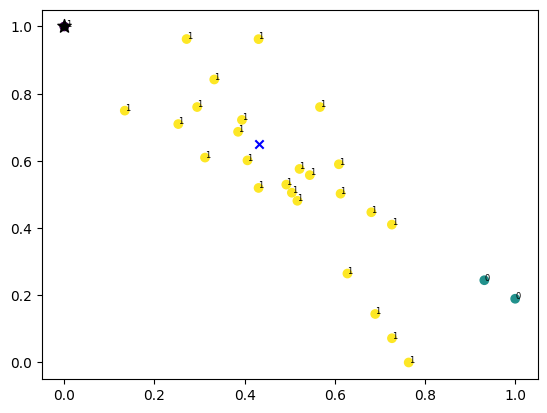

In [15]:
# drop the outliers and re-run the clustering
locs_scaled_filtered = locs_scaled[~outliers_avg_dist]
# re-scale the points
scaler_filtered = sk.preprocessing.MinMaxScaler()
locs_scaled_filtered = scaler_filtered.fit_transform(locs_scaled_filtered)
# re-scale the origin
origin_scaled = scaler_filtered.transform(origin)
clusterer_filtered = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=1, cluster_selection_epsilon=0.5)
clusterer_filtered.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=clusterer_filtered.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# highlight the noise points
plt.scatter(locs_scaled_filtered[clusterer_filtered.labels_==-1,0],locs_scaled_filtered[clusterer_filtered.labels_==-1,1],color='black', marker='*',s=100)
# annotate each point with the corresponding cluster label
for i in range(len(locs_scaled_filtered)):
	plt.annotate(clusterer_filtered.labels_[i], (locs_scaled_filtered[i,0],locs_scaled_filtered[i,1]), size=6)

plt.show()


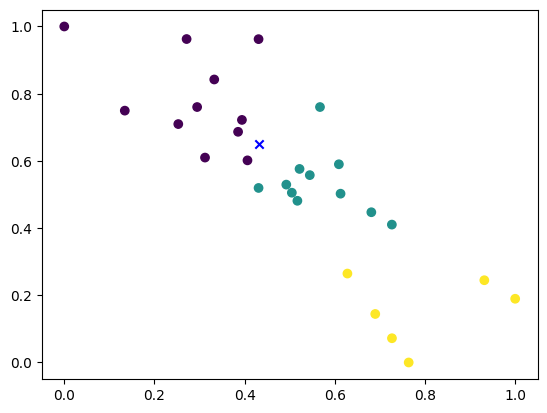

In [16]:
# run spectral clustering on the locational data
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=5)
spectral.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=spectral.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()



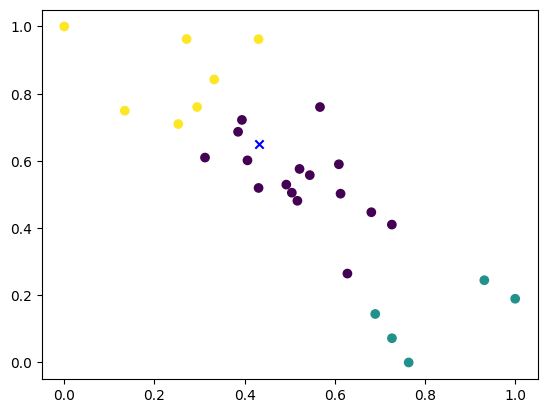

In [17]:
# try hierarchical clustering on the filtered locational data
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=agg.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()

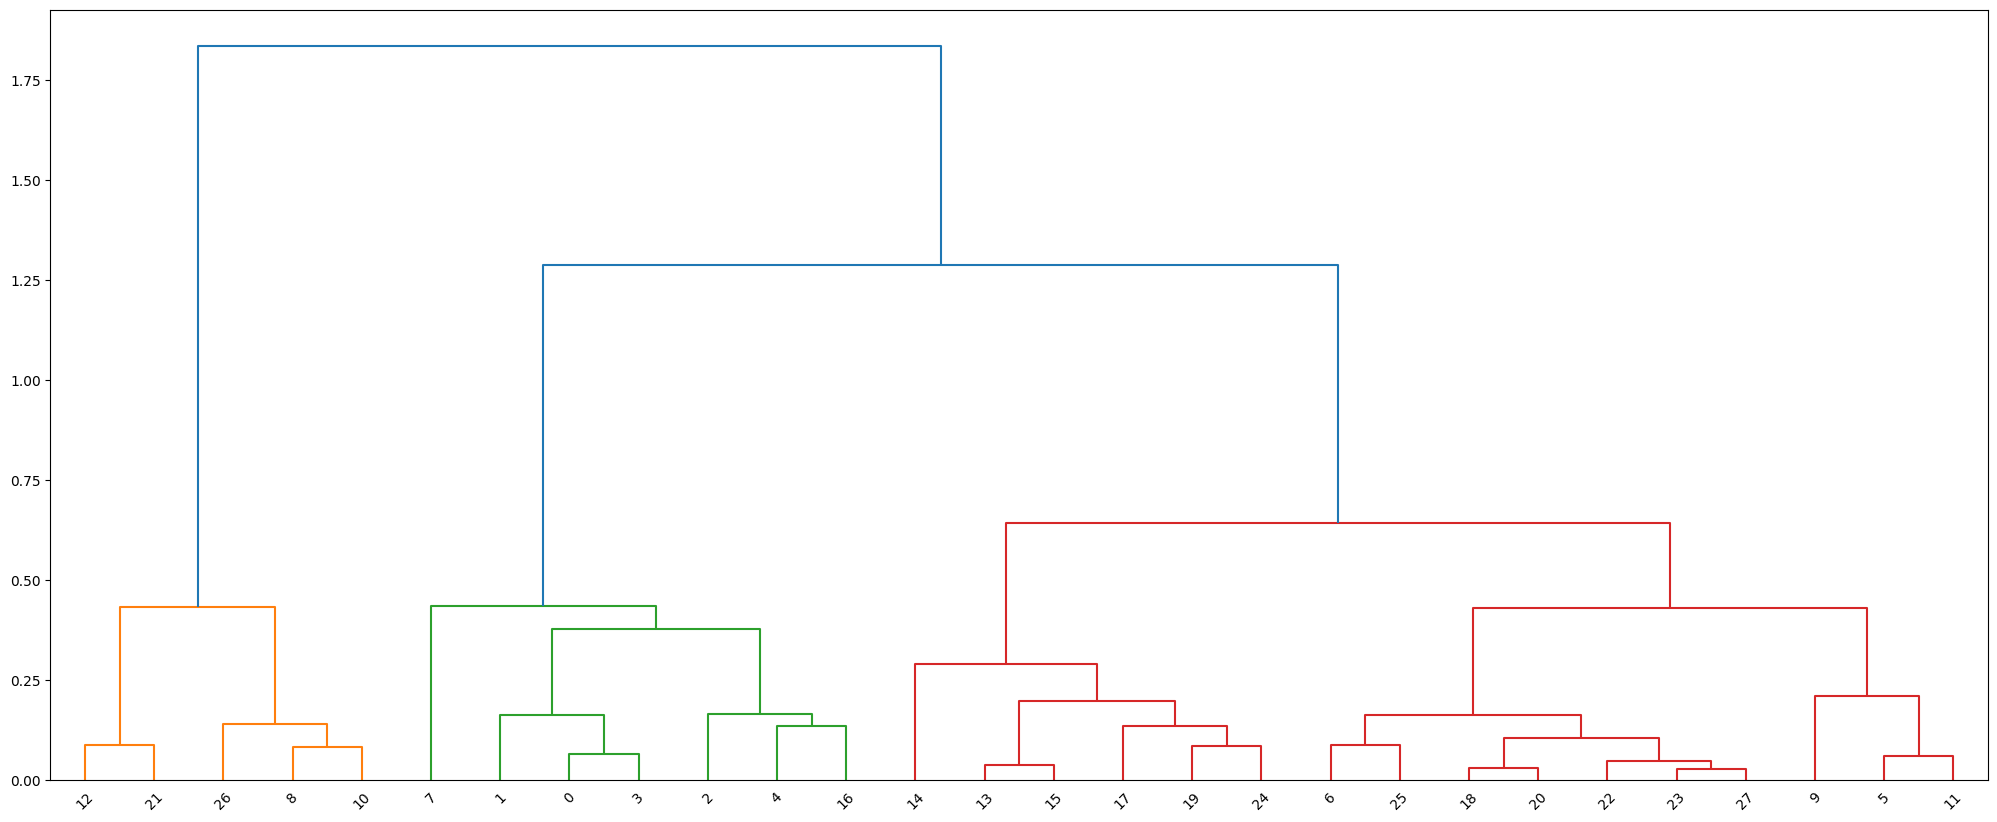

In [18]:
# show the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(locs_scaled_filtered, 'ward')
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

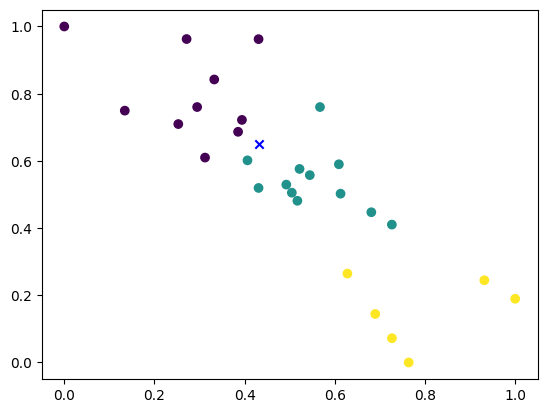

In [19]:
# try k-means clustering on the filtered locational data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init=100)
kmeans.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=kmeans.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()


In [20]:
# compute NMI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(agg.labels_, kmeans.labels_)
print('NMI between hierarchical clustering and k-means clustering:',nmi)

# compute NMI between the hierarchical clustering and the spectral clustering
nmi = normalized_mutual_info_score(agg.labels_, spectral.labels_)
print('NMI between hierarchical clustering and spectral clustering:',nmi)

# compute NMI between the k-means clustering and the spectral clustering
nmi = normalized_mutual_info_score(kmeans.labels_, spectral.labels_)
print('NMI between k-means clustering and spectral clustering:',nmi)



NMI between hierarchical clustering and k-means clustering: 0.6479580173812326
NMI between hierarchical clustering and spectral clustering: 0.6083166891592945
NMI between k-means clustering and spectral clustering: 0.8858389538568711


In [21]:
# Compute ARI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import adjusted_rand_score
ari = adjusted_rand_score(agg.labels_, kmeans.labels_)
print('ARI between hierarchical clustering and k-means clustering:',ari)

# Compute ARI between the hierarchical clustering and the spectral clustering
ari = adjusted_rand_score(agg.labels_, spectral.labels_)
print('ARI between hierarchical clustering and spectral clustering:',ari)

# Compute ARI between the k-means clustering and the spectral clustering
ari = adjusted_rand_score(kmeans.labels_, spectral.labels_)
print('ARI between k-means clustering and spectral clustering:',ari)

ARI between hierarchical clustering and k-means clustering: 0.5633270321361059
ARI between hierarchical clustering and spectral clustering: 0.47766529484214004
ARI between k-means clustering and spectral clustering: 0.8747514910536779


In [22]:
# Compute ARI between the HDBSCAN clustering and the k-means clustering
ari = adjusted_rand_score(clusterer_filtered.labels_, kmeans.labels_)
print('ARI between HDBSCAN clustering and k-means clustering:',ari)

# Compute ARI between the HDBSCAN clustering and the spectral clustering
ari = adjusted_rand_score(clusterer_filtered.labels_, spectral.labels_)
print('ARI between HDBSCAN clustering and spectral clustering:',ari)

# Compute ARI between the HDBSCAN clustering and the hierarchical clustering
ari = adjusted_rand_score(clusterer_filtered.labels_, agg.labels_)
print('ARI between HDBSCAN clustering and hierarchical clustering:',ari)

ARI between HDBSCAN clustering and k-means clustering: 0.07658321060382917
ARI between HDBSCAN clustering and spectral clustering: 0.06577444099885751
ARI between HDBSCAN clustering and hierarchical clustering: 0.17737699177026792


In [23]:
# Compute silouhette score for the k-means clustering
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(locs_scaled_filtered, kmeans.labels_)
print('Silhouette score for k-means clustering:',sil_score)

# Compute silouhette score for the spectral clustering
sil_score = silhouette_score(locs_scaled_filtered, spectral.labels_)
print('Silhouette score for spectral clustering:',sil_score)

# Compute silouhette score for the hierarchical clustering
sil_score = silhouette_score(locs_scaled_filtered, agg.labels_)
print('Silhouette score for hierarchical clustering:',sil_score)

Silhouette score for k-means clustering: 0.45936357241965087
Silhouette score for spectral clustering: 0.4451885384667301
Silhouette score for hierarchical clustering: 0.43571747751336076


In [24]:
# Compute Davies-Bouldin index for the k-means clustering
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(locs_scaled_filtered, kmeans.labels_)
print('Davies-Bouldin index for k-means clustering:',db_score)

# Compute Davies-Bouldin index for the spectral clustering
db_score = davies_bouldin_score(locs_scaled_filtered, spectral.labels_)
print('Davies-Bouldin index for spectral clustering:',db_score)

# Compute Davies-Bouldin index for the hierarchical clustering
db_score = davies_bouldin_score(locs_scaled_filtered, agg.labels_)
print('Davies-Bouldin index for hierarchical clustering:',db_score)

Davies-Bouldin index for k-means clustering: 0.6607352016634597
Davies-Bouldin index for spectral clustering: 0.6710313242782209
Davies-Bouldin index for hierarchical clustering: 0.6612671894371692


In [25]:
# Compute Calinski-Harabasz index for the k-means clustering
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(locs_scaled_filtered, kmeans.labels_)
print('Calinski-Harabasz index for k-means clustering:',ch_score)

# Compute Calinski-Harabasz index for the spectral clustering
ch_score = calinski_harabasz_score(locs_scaled_filtered, spectral.labels_)
print('Calinski-Harabasz index for spectral clustering:',ch_score)

# Compute Calinski-Harabasz index for the hierarchical clustering
ch_score = calinski_harabasz_score(locs_scaled_filtered, agg.labels_)
print('Calinski-Harabasz index for hierarchical clustering:',ch_score)

Calinski-Harabasz index for k-means clustering: 49.276304585917345
Calinski-Harabasz index for spectral clustering: 47.1646913648979
Calinski-Harabasz index for hierarchical clustering: 42.715351863100565


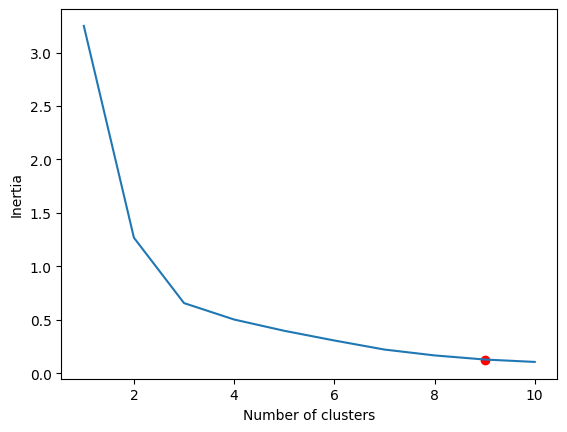

In [26]:
# run elbow method to determine the optimal number of clusters for k-means clustering
inertia = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, random_state=0, n_init=100)
	kmeans.fit(locs_scaled_filtered)
	inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.scatter(9, inertia[8], color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

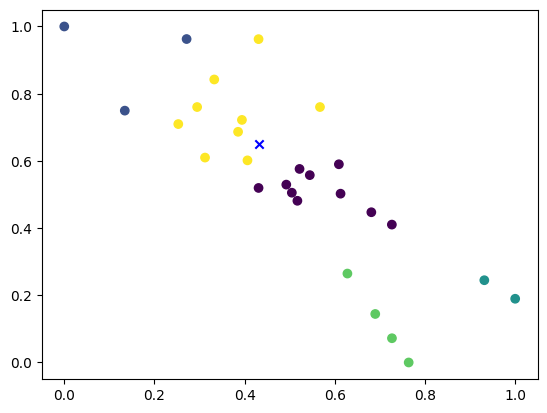

In [27]:
# rerun k-means clustering with the 3 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=100)
kmeans.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=kmeans.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()


In [28]:
# rerun k-means clustering with the 3 clusters
n=5

def kmeans_clustering(n):

	kmeans = KMeans(n_clusters=n, random_state=0, n_init=100)
	kmeans.fit(locs_scaled_filtered)

	# plot the clusters
	# plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=kmeans.labels_)
	# plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
	# plt.show()




	# now compute the silhouette score for the 3-cluster k-means clustering
	sil_score = silhouette_score(locs_scaled_filtered, kmeans.labels_)
	print(f'Silhouette score for {n}-cluster k-means clustering:',sil_score)

	# now compute the Davies-Bouldin index for the 3-cluster k-means clustering
	db_score = davies_bouldin_score(locs_scaled_filtered, kmeans.labels_)
	print(f'Davies-Bouldin index for {n}-cluster k-means clustering:',db_score)

	# now compute the Calinski-Harabasz index for the 3-cluster k-means clustering
	ch_score = calinski_harabasz_score(locs_scaled_filtered, kmeans.labels_)
	print(f'Calinski-Harabasz index for {n}-cluster k-means clustering:',ch_score)

In [29]:
for i in range(2,10):
	kmeans_clustering(i)

Silhouette score for 2-cluster k-means clustering: 0.5178147004642039
Davies-Bouldin index for 2-cluster k-means clustering: 0.6433624618303299
Calinski-Harabasz index for 2-cluster k-means clustering: 40.58910288568107
Silhouette score for 3-cluster k-means clustering: 0.45936357241965087
Davies-Bouldin index for 3-cluster k-means clustering: 0.6607352016634597
Calinski-Harabasz index for 3-cluster k-means clustering: 49.276304585917345
Silhouette score for 4-cluster k-means clustering: 0.3874366080379195
Davies-Bouldin index for 4-cluster k-means clustering: 0.8071274697155987
Calinski-Harabasz index for 4-cluster k-means clustering: 43.59758274773721
Silhouette score for 5-cluster k-means clustering: 0.4026239467768335
Davies-Bouldin index for 5-cluster k-means clustering: 0.7263048565757904
Calinski-Harabasz index for 5-cluster k-means clustering: 41.1346204278584
Silhouette score for 6-cluster k-means clustering: 0.40588363244850695
Davies-Bouldin index for 6-cluster k-means clust

In [30]:
# write the same function for spectral clustering
def spectral_clustering(n):

	spectral = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', n_neighbors=5)
	spectral.fit(locs_scaled_filtered)

	# plot the clusters
	# plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=spectral.labels_)
	# plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
	# plt.show()

	# now compute the silhouette score for the 3-cluster spectral clustering
	sil_score = silhouette_score(locs_scaled_filtered, spectral.labels_)
	print(f'Silhouette score for {n}-cluster spectral clustering:',sil_score)

	# now compute the Davies-Bouldin index for the 3-cluster spectral clustering
	db_score = davies_bouldin_score(locs_scaled_filtered, spectral.labels_)
	print(f'Davies-Bouldin index for {n}-cluster spectral clustering:',db_score)

	# now compute the Calinski-Harabasz index for the 3-cluster spectral clustering
	ch_score = calinski_harabasz_score(locs_scaled_filtered, spectral.labels_)
	print(f'Calinski-Harabasz index for {n}-cluster spectral clustering:',ch_score)

for i in range(2,10):
	spectral_clustering(i)

Silhouette score for 2-cluster spectral clustering: 0.49043051133644183
Davies-Bouldin index for 2-cluster spectral clustering: 0.6832964793005444
Calinski-Harabasz index for 2-cluster spectral clustering: 40.04007856915739
Silhouette score for 3-cluster spectral clustering: 0.4451885384667301
Davies-Bouldin index for 3-cluster spectral clustering: 0.6710313242782209
Calinski-Harabasz index for 3-cluster spectral clustering: 47.1646913648979
Silhouette score for 4-cluster spectral clustering: 0.31690857962635427
Davies-Bouldin index for 4-cluster spectral clustering: 0.7854661997005932
Calinski-Harabasz index for 4-cluster spectral clustering: 39.255516462046494
Silhouette score for 5-cluster spectral clustering: 0.29792838054423815
Davies-Bouldin index for 5-cluster spectral clustering: 0.8469466911184927
Calinski-Harabasz index for 5-cluster spectral clustering: 35.39568316829867
Silhouette score for 6-cluster spectral clustering: 0.26824278615007185
Davies-Bouldin index for 6-cluste

In [31]:
# write the same function for hierarchical clustering
def hierarchical_clustering(n):

	agg = AgglomerativeClustering(n_clusters=n)
	agg.fit(locs_scaled_filtered)

	# plot the clusters
	# plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=agg.labels_)
	# plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
	# plt.show()

	# now compute the silhouette score for the 3-cluster hierarchical clustering
	sil_score = silhouette_score(locs_scaled_filtered, agg.labels_)
	print(f'Silhouette score for {n}-cluster hierarchical clustering:',sil_score)

	# now compute the Davies-Bouldin index for the 3-cluster hierarchical clustering
	db_score = davies_bouldin_score(locs_scaled_filtered, agg.labels_)
	print(f'Davies-Bouldin index for {n}-cluster hierarchical clustering:',db_score)

	# now compute the Calinski-Harabasz index for the 3-cluster hierarchical clustering
	ch_score = calinski_harabasz_score(locs_scaled_filtered, agg.labels_)
	print(f'Calinski-Harabasz index for {n}-cluster hierarchical clustering:',ch_score)

for i in range(2,10):
	hierarchical_clustering(i)

Silhouette score for 2-cluster hierarchical clustering: 0.5087683643928952
Davies-Bouldin index for 2-cluster hierarchical clustering: 0.5703377524518575
Calinski-Harabasz index for 2-cluster hierarchical clustering: 27.943802121597553
Silhouette score for 3-cluster hierarchical clustering: 0.43571747751336076
Davies-Bouldin index for 3-cluster hierarchical clustering: 0.6612671894371692
Calinski-Harabasz index for 3-cluster hierarchical clustering: 42.715351863100565
Silhouette score for 4-cluster hierarchical clustering: 0.32384762856667476
Davies-Bouldin index for 4-cluster hierarchical clustering: 0.8527353663635253
Calinski-Harabasz index for 4-cluster hierarchical clustering: 41.07050894983257
Silhouette score for 5-cluster hierarchical clustering: 0.31620897041294954
Davies-Bouldin index for 5-cluster hierarchical clustering: 0.7733317218110602
Calinski-Harabasz index for 5-cluster hierarchical clustering: 37.1896107541312
Silhouette score for 6-cluster hierarchical clustering: 

In [32]:
# write the same function for hierarchical clustering, but with ward linkage and euclidean distance
def hierarchical_clustering_ward(n):

	agg = AgglomerativeClustering(n_clusters=n, linkage='complete', metric='euclidean')
	agg.fit(locs_scaled_filtered)

	# plot the clusters
	# plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=agg.labels_)
	# plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
	# plt.show()

	# now compute the silhouette score for the 3-cluster hierarchical clustering
	sil_score = silhouette_score(locs_scaled_filtered, agg.labels_)
	print(f'Silhouette score for {n}-cluster hierarchical clustering:',sil_score)

	# now compute the Davies-Bouldin index for the 3-cluster hierarchical clustering
	db_score = davies_bouldin_score(locs_scaled_filtered, agg.labels_)
	print(f'Davies-Bouldin index for {n}-cluster hierarchical clustering:',db_score)

	# now compute the Calinski-Harabasz index for the 3-cluster hierarchical clustering
	ch_score = calinski_harabasz_score(locs_scaled_filtered, agg.labels_)
	print(f'Calinski-Harabasz index for {n}-cluster hierarchical clustering:',ch_score)

for i in range(2,10):
	hierarchical_clustering_ward(i)

Silhouette score for 2-cluster hierarchical clustering: 0.4266671763725393
Davies-Bouldin index for 2-cluster hierarchical clustering: 0.7381551521288777
Calinski-Harabasz index for 2-cluster hierarchical clustering: 30.84757096254557
Silhouette score for 3-cluster hierarchical clustering: 0.41614352723845427
Davies-Bouldin index for 3-cluster hierarchical clustering: 0.6897663162872353
Calinski-Harabasz index for 3-cluster hierarchical clustering: 45.739923685115215
Silhouette score for 4-cluster hierarchical clustering: 0.39101230369362444
Davies-Bouldin index for 4-cluster hierarchical clustering: 0.5982764302010488
Calinski-Harabasz index for 4-cluster hierarchical clustering: 37.96510693844148
Silhouette score for 5-cluster hierarchical clustering: 0.3537104856429089
Davies-Bouldin index for 5-cluster hierarchical clustering: 0.6780959786130935
Calinski-Harabasz index for 5-cluster hierarchical clustering: 39.249117387872836
Silhouette score for 6-cluster hierarchical clustering: 

In [33]:
# write the same function for hierarchical clustering, but with ward linkage and euclidean distance
def hierarchical_clustering_ward(n):

	agg = AgglomerativeClustering(n_clusters=n, linkage='average', metric='euclidean')
	agg.fit(locs_scaled_filtered)

	# plot the clusters
	# plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=agg.labels_)
	# plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
	# plt.show()

	# now compute the silhouette score for the 3-cluster hierarchical clustering
	sil_score = silhouette_score(locs_scaled_filtered, agg.labels_)
	print(f'Silhouette score for {n}-cluster hierarchical clustering:',sil_score)

	# now compute the Davies-Bouldin index for the 3-cluster hierarchical clustering
	db_score = davies_bouldin_score(locs_scaled_filtered, agg.labels_)
	print(f'Davies-Bouldin index for {n}-cluster hierarchical clustering:',db_score)

	# now compute the Calinski-Harabasz index for the 3-cluster hierarchical clustering
	ch_score = calinski_harabasz_score(locs_scaled_filtered, agg.labels_)
	print(f'Calinski-Harabasz index for {n}-cluster hierarchical clustering:',ch_score)

for i in range(2,10):
	hierarchical_clustering_ward(i)

Silhouette score for 2-cluster hierarchical clustering: 0.5087683643928952
Davies-Bouldin index for 2-cluster hierarchical clustering: 0.5703377524518575
Calinski-Harabasz index for 2-cluster hierarchical clustering: 27.943802121597553
Silhouette score for 3-cluster hierarchical clustering: 0.36247262540872455
Davies-Bouldin index for 3-cluster hierarchical clustering: 0.4892102616879681
Calinski-Harabasz index for 3-cluster hierarchical clustering: 20.469419764591322
Silhouette score for 4-cluster hierarchical clustering: 0.392712635480455
Davies-Bouldin index for 4-cluster hierarchical clustering: 0.5808466266015655
Calinski-Harabasz index for 4-cluster hierarchical clustering: 36.36293663480825
Silhouette score for 5-cluster hierarchical clustering: 0.3989967876867409
Davies-Bouldin index for 5-cluster hierarchical clustering: 0.4960006091417675
Calinski-Harabasz index for 5-cluster hierarchical clustering: 32.215585955192665
Silhouette score for 6-cluster hierarchical clustering: 0

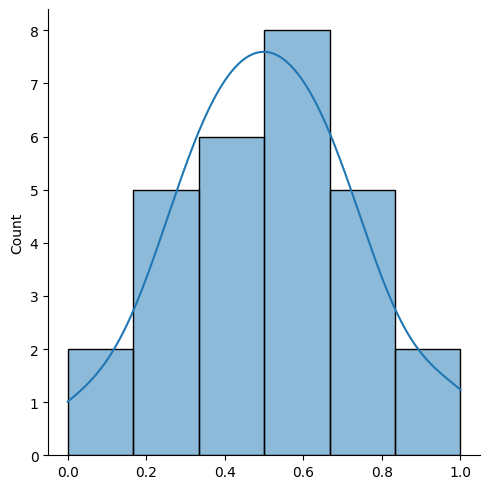

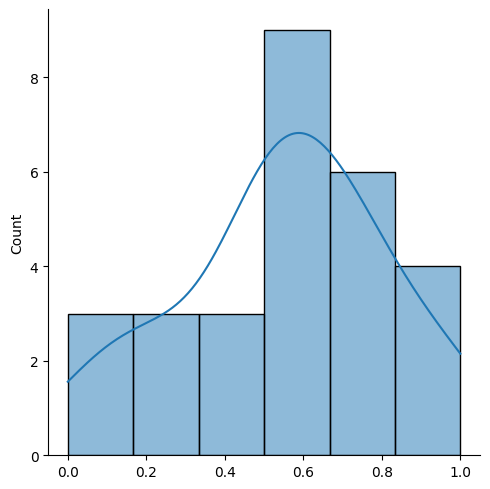

Mean of x: 0.5057843843255729
Mean of y: 0.5500346888298261
Standard deviation of x: 0.22119586445430808
Standard deviation of y: 0.2590435333262841


In [34]:
# plot the distribution of x and y coordinates for the filtered locational data
sns.displot(locs_scaled_filtered[:,0], kde=True)
plt.show()
sns.displot(locs_scaled_filtered[:,1], kde=True)
plt.show()

# compute mean and standard deviation of x and y coordinates for the filtered locational data
print('Mean of x:',np.mean(locs_scaled_filtered[:,0]))
print('Mean of y:',np.mean(locs_scaled_filtered[:,1]))
print('Standard deviation of x:',np.std(locs_scaled_filtered[:,0]))
print('Standard deviation of y:',np.std(locs_scaled_filtered[:,1]))


Original clustering: [0 0 3 0 3 5 2 6 1 5 1 5 4 7 8 7 3 7 2 7 2 4 2 2 2 2 1 2]
Noisy clustering: [8 2 7 8 7 5 5 2 6 0 6 0 4 8 3 8 7 1 5 1 1 4 5 5 8 3 6 1]


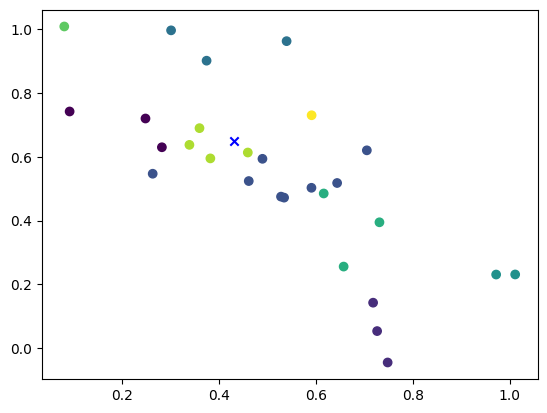

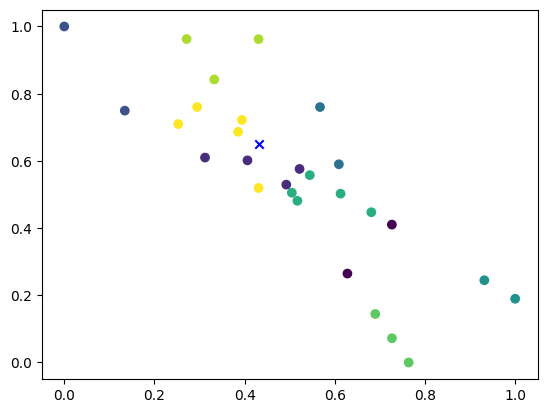

ARI between original clustering and noisy clustering: 0.3652733118971061
NMI between original clustering and noisy clustering: 0.7448452067337428


In [35]:
# now introduce some noise in the locational data and re-run the clustering to check the robustness of the clustering algorithms

# introduce noise in the locational data
locs_scaled_noisy = locs_scaled_filtered.copy()
# introduce noise in the x co-ordinates
locs_scaled_noisy[:,0] = locs_scaled_noisy[:,0] + np.random.normal(0,0.05,len(locs_scaled_noisy))	
# introduce noise in the y co-ordinates
locs_scaled_noisy[:,1] = locs_scaled_noisy[:,1] + np.random.normal(0,0.05,len(locs_scaled_noisy))

# re-run the k-means clustering
kmeans_noisy = KMeans(n_clusters=9, random_state=0, n_init=100)
kmeans_noisy.fit(locs_scaled_noisy)

kmeans = KMeans(n_clusters=9, random_state=0, n_init=100)
kmeans.fit(locs_scaled_filtered)

print('Original clustering:',kmeans.labels_)
print('Noisy clustering:',kmeans_noisy.labels_)

# plot the clusters
plt.scatter(locs_scaled_noisy[:,0],locs_scaled_noisy[:,1],c=kmeans.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()

plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=kmeans_noisy.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()

# compute agreement between the original clustering and the noisy clustering
ari = adjusted_rand_score(kmeans.labels_, kmeans_noisy.labels_)
print('ARI between original clustering and noisy clustering:',ari)

nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_noisy.labels_)
print('NMI between original clustering and noisy clustering:',nmi)

In [36]:
# same as above, but with NMI

nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_noisy.labels_)

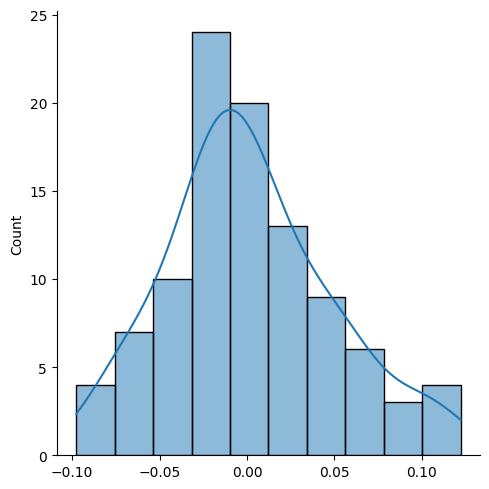

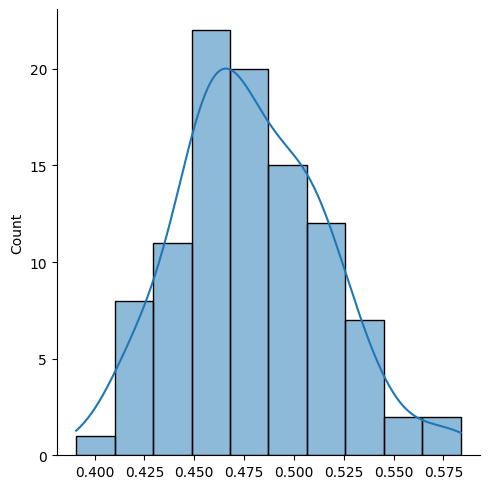

In [37]:
# now do bootstrapping to check the robustness of the clustering algorithms
from sklearn.utils import resample
n_bootstraps = 100
ari_scores = []
nmi_scores = []
for i in range(n_bootstraps):
	# resample the data
	locs_scaled_resampled = resample(locs_scaled_filtered, replace=True, n_samples=len(locs_scaled_filtered))
	# re-run the k-means clustering
	kmeans_resampled = KMeans(n_clusters=9, random_state=0, n_init=100)
	kmeans_resampled.fit(locs_scaled_resampled)
	# compute ARI
	ari = adjusted_rand_score(kmeans.labels_, kmeans_resampled.labels_)
	ari_scores.append(ari)
	# compute NMI
	nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_resampled.labels_)
	nmi_scores.append(nmi)

# plot the distribution of ARI scores
sns.displot(ari_scores, kde=True)
plt.show()
# plot the distribution of NMI scores
sns.displot(nmi_scores, kde=True)
plt.show()


In [38]:
print(ari_scores)
print(np.array(nmi_scores).tolist())

[-0.0691007263611236, -0.0746827543166216, -0.017645150827116447, 0.04889493369602176, 0.003952569169960474, 0.09089622975171535, -0.016057154983376953, 0.10938328326559463, -0.016057154983376953, -0.022259205325566883, 0.0951268167569108, -0.08053113665703572, 0.03375586525667063, 0.0036542263224105913, 0.04526166902404526, -0.01473187978786093, -0.018989995806625533, 0.0036542263224105913, -0.012861736334405145, 0.05591955887122932, -0.05392723563413805, 0.019801980198019802, -0.012861736334405145, 0.01647875108412836, 0.0036542263224105913, -0.04279550116715003, -0.046474642162926315, -0.022259205325566883, -0.010819450421097929, 0.060228307304433085, 0.03016434366548783, 0.05951679434295816, 0.041697244646073786, 0.04889493369602176, -0.023313586852665776, 0.06937693327441449, 0.12218649517684887, 0.0008316008316008316, -0.07718189933392845, -0.06688102893890675, 0.09618104667609619, 0.01647875108412836, -0.031117397454031116, 0.048942670580482836, -0.013590102992260345, 0.04497220

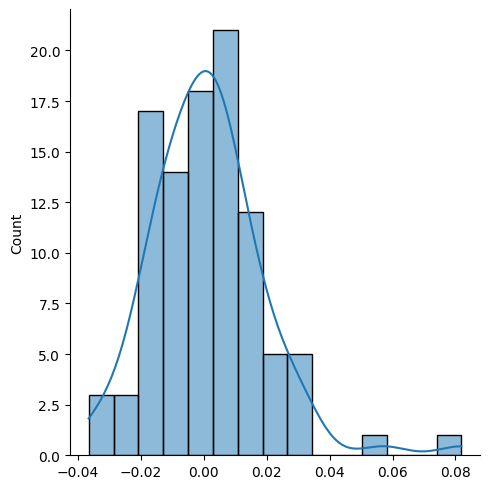

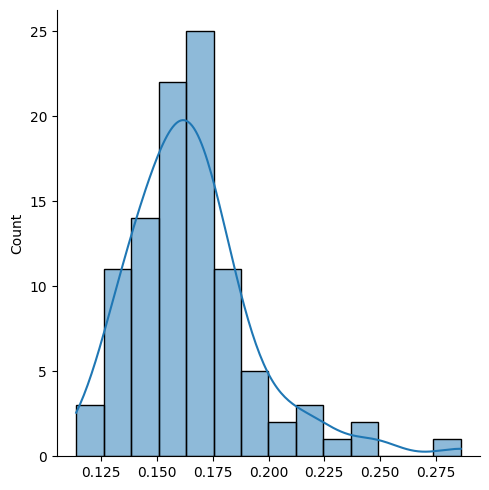

In [39]:
# do the same with HDBSCAN clustering
n_bootstraps = 100
ari_scores = []
nmi_scores = []
for i in range(n_bootstraps):
	print(i, end='\r')
	# resample the data
	locs_scaled_resampled = resample(locs_scaled_filtered, replace=True, n_samples=len(locs_scaled_filtered))
	# re-run the HDBSCAN clustering
	clusterer_resampled = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=1)
	clusterer_resampled.fit(locs_scaled_resampled)
	# compute ARI
	ari = adjusted_rand_score(clusterer_filtered.labels_, clusterer_resampled.labels_)
	ari_scores.append(ari)
	# compute NMI
	nmi = normalized_mutual_info_score(clusterer_filtered.labels_, clusterer_resampled.labels_)
	nmi_scores.append(nmi)

# plot the distribution of ARI scores
sns.displot(ari_scores, kde=True)
plt.show()
# plot the distribution of NMI scores
sns.displot(nmi_scores, kde=True)
plt.show()

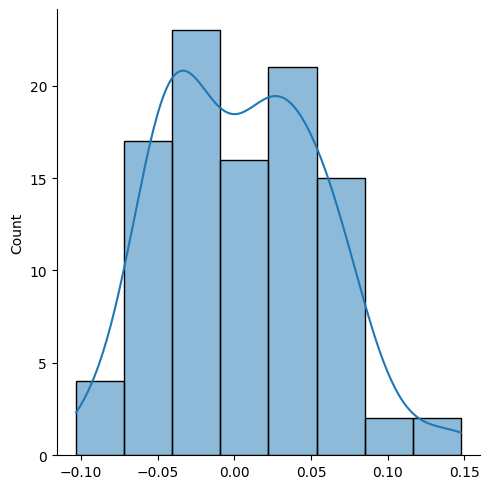

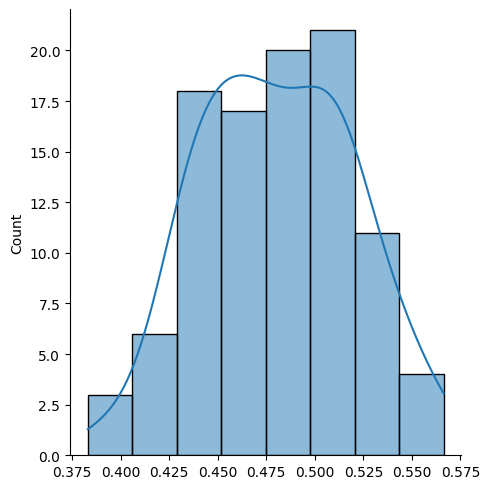

In [40]:
# now do bootstrapping to check the robustness of the clustering algorithms
from sklearn.utils import resample
n_bootstraps = 100
ari_scores = []
nmi_scores = []
for i in range(n_bootstraps):
	# resample the data
	locs_scaled_resampled = resample(locs_scaled_filtered, replace=True, n_samples=len(locs_scaled_filtered))
	# re-run the k-means clustering
	kmeans_resampled = KMeans(n_clusters=9, random_state=0, n_init=10)
	kmeans_resampled.fit(locs_scaled_resampled)
	kmeans_2 = KMeans(n_clusters=9, random_state=0, n_init=10)
	kmeans_2.fit(locs_scaled_filtered)
	# compute ARI
	ari = adjusted_rand_score(kmeans_2.labels_, kmeans_resampled.labels_)
	ari_scores.append(ari)
	# compute NMI
	nmi = normalized_mutual_info_score(kmeans_2.labels_, kmeans_resampled.labels_)
	nmi_scores.append(nmi)

# plot the distribution of ARI scores
sns.displot(ari_scores, kde=True)
plt.show()
# plot the distribution of NMI scores
sns.displot(nmi_scores, kde=True)
plt.show()


In [41]:
print(ari_scores)
print(np.array(nmi_scores).tolist())

print(nmi_scores)


[-0.06417382516422436, 0.07668573632448415, -0.020505238799254356, 0.14766286793832653, -0.017645150827116447, 0.08258789265654254, 0.13501144164759726, 0.04526166902404526, 0.05591955887122932, 0.045936395759717315, -0.002209456473707468, -0.05917672960170792, 0.06318154781574252, 0.0072834232089081866, 0.07855524273844675, 0.023189391363481807, 0.026642862047655015, -0.044802982580188985, -0.03948143783146729, 0.013217897032582117, -0.033958236039762495, 0.09707624689470667, -0.017645150827116447, -0.10313808967932432, 0.03016434366548783, -0.022259205325566883, -0.028221693301598096, -0.07926725843840109, -0.05392723563413805, 0.052202283849918436, 0.02936378466557912, -0.022259205325566883, 0.03016434366548783, 0.023284823284823286, -0.03987138263665595, 0.03016434366548783, 0.00068667170225915, 0.05516290294776763, 0.021652673442333185, 0.08044112877067791, 0.03375586525667063, -0.052430707626853534, -0.051155784716992066, -0.019189018838854262, 0.019801980198019802, -0.0096008084

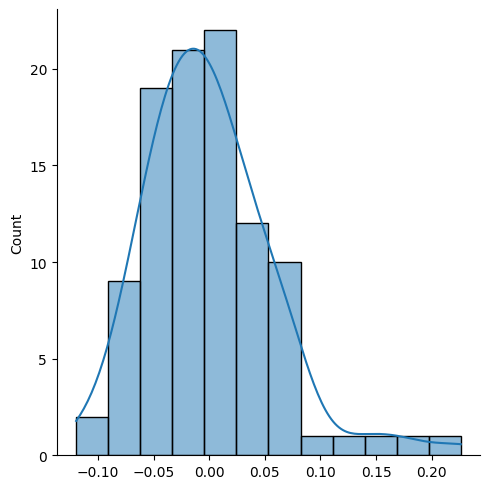

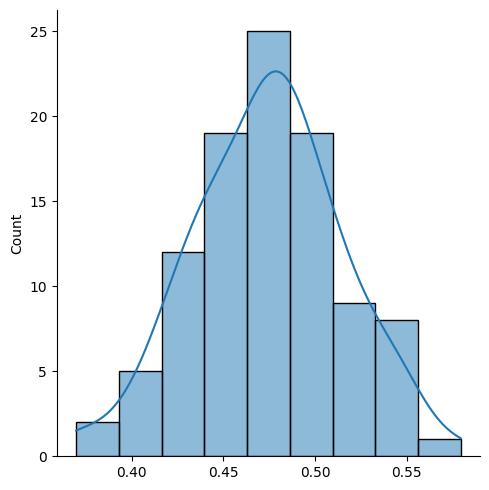

In [42]:
# make robustness function
def clustering_robustness(clustering_algorithm, n_clusters, n_bootstraps=100):
	ari_scores = []
	nmi_scores = []
	for i in range(n_bootstraps):
		print(i,end='\r')
		# resample the data
		locs_scaled_resampled = resample(locs_scaled_filtered, replace=True, n_samples=len(locs_scaled_filtered))
		# re-run the clustering algorithm
		clustering_resampled = clustering_algorithm(n_clusters)
		clustering_resampled.fit(locs_scaled_resampled)
		# orignal clustering
		clustering = clustering_algorithm(9)
		clustering.fit(locs_scaled_filtered)
		# compute ARI
		ari = adjusted_rand_score(clustering.labels_, clustering_resampled.labels_)
		ari_scores.append(ari)
		# compute NMI
		nmi = normalized_mutual_info_score(clustering.labels_, clustering_resampled.labels_)
		nmi_scores.append(nmi)
	return ari_scores, nmi_scores

# run the robustness function for k-means clustering
ari_scores, nmi_scores = clustering_robustness(KMeans, 9, 100)

sns.displot(ari_scores, kde=True)
plt.show()
sns.displot(nmi_scores, kde=True)
plt.show()

In [43]:
# compute count of points in each cluster for the original clustering
print(np.bincount(kmeans.labels_))


[3 3 8 3 2 3 1 4 1]


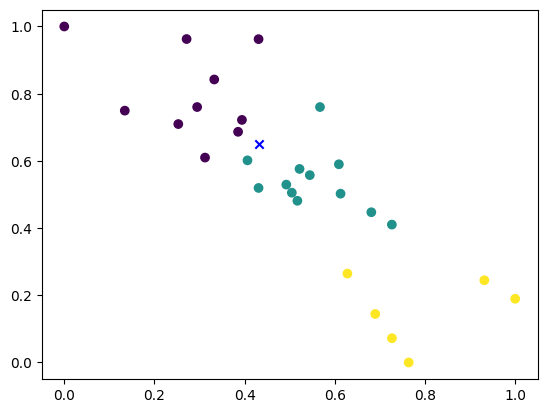

[10 12  6]


In [44]:
# run k-means clustering with 5
kmeans = KMeans(n_clusters=3, random_state=0, n_init=100)
kmeans.fit(locs_scaled_filtered)

# plot the clusters
plt.scatter(locs_scaled_filtered[:,0],locs_scaled_filtered[:,1],c=kmeans.labels_)
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.show()

# compute count of points in each cluster for the 5-cluster k-means clustering
print(np.bincount(kmeans.labels_))

In [45]:
#print which points are in which cluster
for i in range(3):
	print('Points in cluster',i,':',np.where(kmeans.labels_==i)[0])

# find reference against the original points
# reverse the scaling
locs_unscaled = scaler_filtered.inverse_transform(locs_scaled_filtered)
# find the original points
original_points = locs[np.where(~outliers_avg_dist)[0]]
# find the indices of the original points
original_indices = np.where(~outliers_avg_dist)[0]
# find the indices of the points in each cluster
cluster_indices = []
for i in range(3):
	cluster_indices.append(np.where(kmeans.labels_==i)[0])

# find the nearest original point for each point in each cluster
nearest_original_points = []
for i in range(3):
	nearest_points = []
	for j in cluster_indices[i]:
		# find the nearest original point
		distances = np.linalg.norm(original_points-locs_unscaled[j], axis=1)
		nearest_index = np.argmin(distances)
		nearest_points.append(original_indices[nearest_index])
	nearest_original_points.append(nearest_points)

print(nearest_original_points)

# reverse the mapping
idx_to_cluster = {}
for i in range(3):
	for j in nearest_original_points[i]:
		idx_to_cluster[j] = i

idx_to_cluster


Points in cluster 0 : [ 0  1  2  3  4  7 13 15 16 17]
Points in cluster 1 : [ 5  6 11 14 18 19 20 22 23 24 25 27]
Points in cluster 2 : [ 8  9 10 12 21 26]
[[np.int64(0), np.int64(1), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(15), np.int64(17), np.int64(18), np.int64(19)], [np.int64(7), np.int64(8), np.int64(13), np.int64(16), np.int64(20), np.int64(23), np.int64(24), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(33)], [np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(25), np.int64(32)]]


{np.int64(0): 0,
 np.int64(1): 0,
 np.int64(4): 0,
 np.int64(5): 0,
 np.int64(6): 0,
 np.int64(9): 0,
 np.int64(15): 0,
 np.int64(17): 0,
 np.int64(18): 0,
 np.int64(19): 0,
 np.int64(7): 1,
 np.int64(8): 1,
 np.int64(13): 1,
 np.int64(16): 1,
 np.int64(20): 1,
 np.int64(23): 1,
 np.int64(24): 1,
 np.int64(27): 1,
 np.int64(28): 1,
 np.int64(29): 1,
 np.int64(30): 1,
 np.int64(33): 1,
 np.int64(10): 2,
 np.int64(11): 2,
 np.int64(12): 2,
 np.int64(14): 2,
 np.int64(25): 2,
 np.int64(32): 2}

In [46]:
# put outliers in a separate cluster
for i in np.where(outliers_avg_dist)[0]:
	idx_to_cluster[i] = 3

idx_to_cluster

{np.int64(0): 0,
 np.int64(1): 0,
 np.int64(4): 0,
 np.int64(5): 0,
 np.int64(6): 0,
 np.int64(9): 0,
 np.int64(15): 0,
 np.int64(17): 0,
 np.int64(18): 0,
 np.int64(19): 0,
 np.int64(7): 1,
 np.int64(8): 1,
 np.int64(13): 1,
 np.int64(16): 1,
 np.int64(20): 1,
 np.int64(23): 1,
 np.int64(24): 1,
 np.int64(27): 1,
 np.int64(28): 1,
 np.int64(29): 1,
 np.int64(30): 1,
 np.int64(33): 1,
 np.int64(10): 2,
 np.int64(11): 2,
 np.int64(12): 2,
 np.int64(14): 2,
 np.int64(25): 2,
 np.int64(32): 2,
 np.int64(2): 3,
 np.int64(3): 3,
 np.int64(21): 3,
 np.int64(22): 3,
 np.int64(26): 3,
 np.int64(31): 3}

In [47]:
# create a new dataframe with the cluster information
df_clustered = df.copy()
df_clustered['Cluster'] = [idx_to_cluster[i] for i in range(len(df))]


In [48]:
# group 'Populationi Density' by 'Cluster'
df_clustered.groupby('Cluster')['Population Density'].describe()

# Check if the clusters are statistically different in terms of 'Population Density'
from scipy.stats import f_oneway
cluster_0 = df_clustered[df_clustered['Cluster']==0]['Population Density']
cluster_1 = df_clustered[df_clustered['Cluster']==1]['Population Density']
cluster_2 = df_clustered[df_clustered['Cluster']==2]['Population Density']
cluster_3 = df_clustered[df_clustered['Cluster']==3]['Population Density']
f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)



F_onewayResult(statistic=np.float64(17.455622115452087), pvalue=np.float64(9.569485078184246e-07))

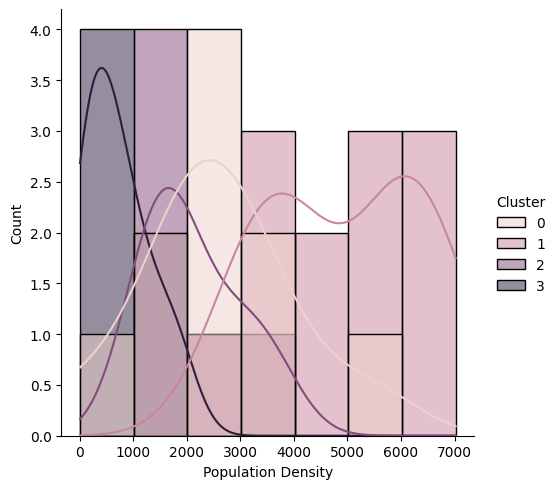

In [49]:
df_clustered.groupby('Cluster')['Population Density'].describe()

# plot the distribution of 'Population Density' for each cluster
sns.displot(df_clustered, x='Population Density', hue='Cluster', kde=True)
plt.show()

In [50]:
# conduct Tukey's HSD test to determine which clusters are different
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df_clustered['Population Density'], df_clustered['Cluster'])
result = mc.tukeyhsd()
print(result)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     0      1  2368.2422 0.0007   900.4726  3836.0118   True
     0      2  -461.9791 0.8925 -2232.1759  1308.2177  False
     0      3 -1862.2345 0.0363 -3632.4313   -92.0378   True
     1      2 -2830.2213 0.0005  -4544.207 -1116.2357   True
     1      3 -4230.4767    0.0 -5944.4624 -2516.4911   True
     2      3 -1400.2554 0.2398 -3379.3956   578.8848  False
------------------------------------------------------------


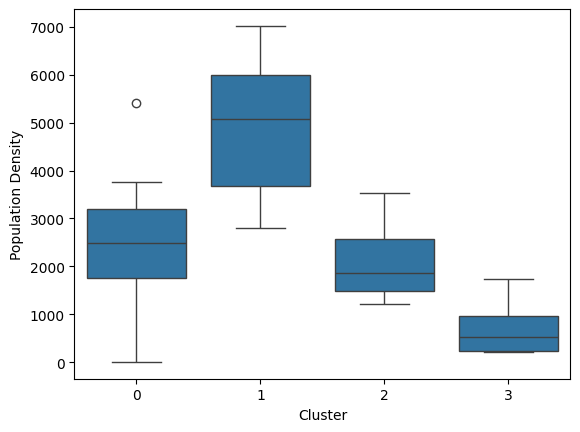

In [51]:
# do boxplot of 'Population Density' for each cluster
sns.boxplot(data=df_clustered, x='Cluster', y='Population Density')
plt.show()

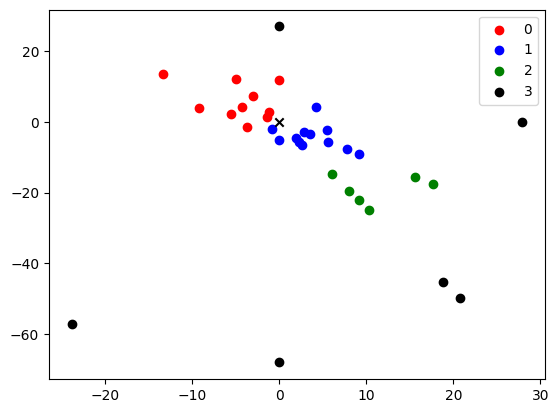

In [52]:
# plot the groups of points in different colors
colors = ['red','blue','green','black']

# group the new dataframe by 'Cluster'
grouped = df_clustered.groupby('Cluster')
# plot the groups
for name, group in grouped:
	plt.scatter(group['cart_x'],group['cart_y'],color=colors[name],label=name)
plt.scatter(0,0,color='black', marker='x')
plt.legend()
plt.show()

In [53]:
print(f'Population Density of cluster 0:\n{df_clustered[df_clustered['Cluster']==0]['Population Density']}')
print(f'Population Density of cluster 1:\n{df_clustered[df_clustered['Cluster']==1]['Population Density']}')
print(f'Population Density of cluster 2:\n{df_clustered[df_clustered['Cluster']==2]['Population Density']}')
print(f'Population Density of cluster 3:\n{df_clustered[df_clustered['Cluster']==3]['Population Density']}')




Population Density of cluster 0:
0     3758.623596
1     2025.468296
4     2619.120089
5     2848.743284
6     2352.122818
9        5.200815
15    5417.942002
17    1652.315391
18    3323.070825
19    1669.114239
Name: Population Density, dtype: float64
Population Density of cluster 1:
7     2795.946571
8     3686.421646
13    3622.007692
16    4157.531892
20    6545.496301
23    4318.648935
24    5853.942037
27    5929.989035
28    6205.348910
29    5893.982048
30    3195.360659
33    7020.296346
Name: Population Density, dtype: float64
Population Density of cluster 2:
10    2799.843733
11    1220.057102
12    1814.169027
14    3525.522434
25    1888.536850
32    1383.028868
Name: Population Density, dtype: float64
Population Density of cluster 3:
2     1034.970870
3     1730.064830
21     749.081534
22     212.389261
26     289.307021
31     213.812038
Name: Population Density, dtype: float64


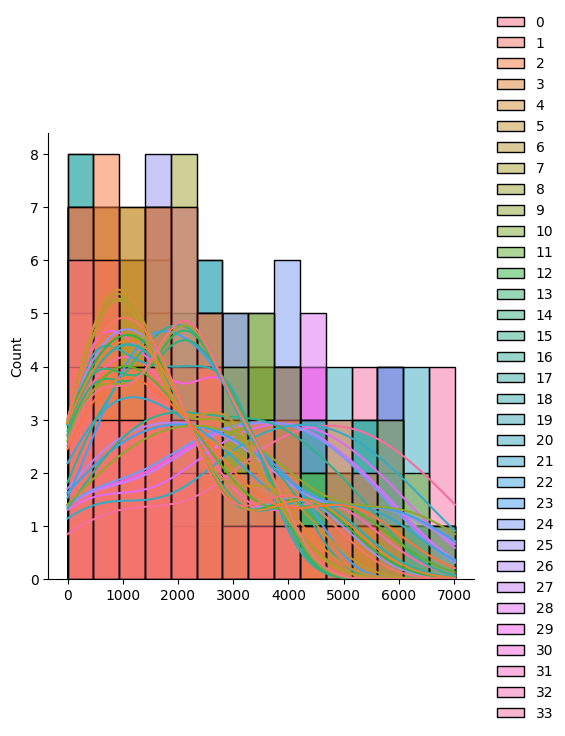

In [54]:
# compute pairwise absolute differences between population densities of the suburbs (don't take clustering into account)
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# compute the pairwise distances
distances = pdist(df['Population Density'].values.reshape(-1,1), 'cityblock')
# convert the distances to a square matrix
dist_matrix_pop = squareform(distances)
# plot the histogram of the distances
sns.displot(dist_matrix_pop, kde=True)
plt.show()

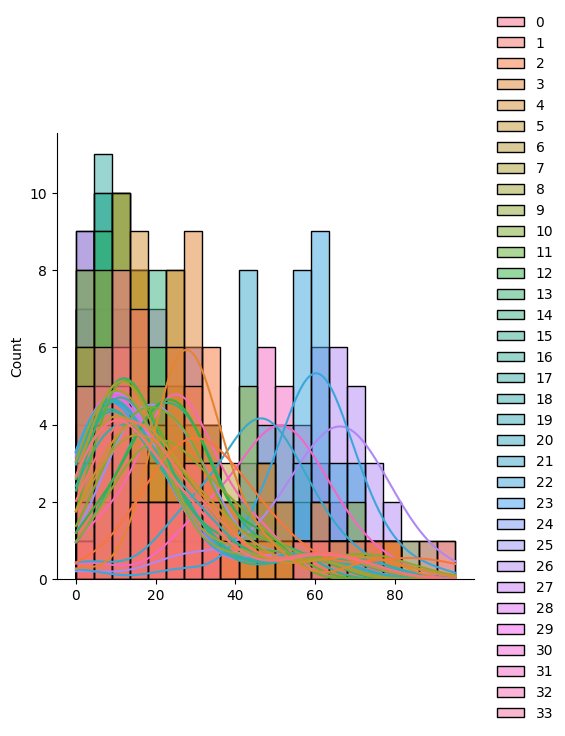

In [55]:
# compute pairwise distances between the suburbs
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# compute the pairwise distances
distances = pdist(locs)
# convert the distances to a square matrix
dist_matrix_suburb = squareform(distances)
# plot the histogram of the distances
sns.displot(dist_matrix_suburb, kde=True)
plt.show()

In [56]:
# check the spearman rank correlation between the population density and the distance from the origin
from scipy.stats import spearmanr
spearmanr(df['Population Density'], np.linalg.norm(locs, axis=1))


SignificanceResult(statistic=np.float64(-0.7011459129106188), pvalue=np.float64(3.863658979290041e-06))

In [57]:
# create a plot of the population density and the pairwise distances between the suburbs
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

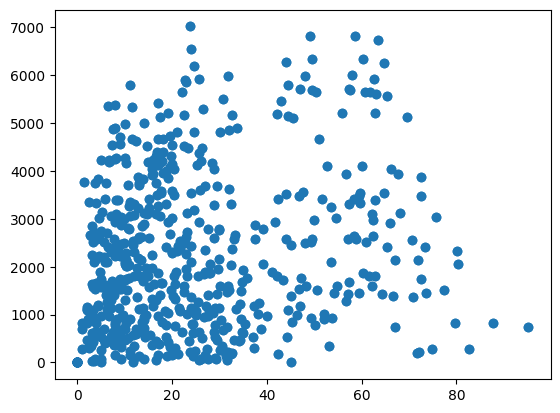

In [107]:
# create a plot of the population density difference and the pairwise distances between the suburbs

# create a plot of the population density and the pairwise distances between the suburbs
plt.scatter(dist_matrix_suburb, dist_matrix_pop)


In [109]:
# test the correlation between the population density and the pairwise distances between the suburbs
from scipy.stats import spearmanr
spearmanr(dist_matrix_suburb.flatten(), dist_matrix_pop.flatten())

SignificanceResult(statistic=np.float64(0.22563175846460468), pvalue=np.float64(8.261346636146706e-15))

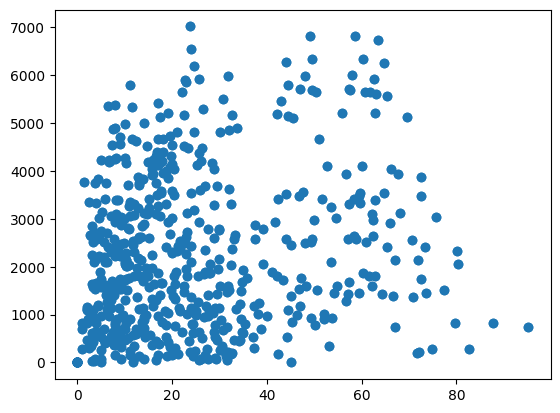

In [111]:
plt.scatter(dist_matrix_suburb.flatten(), dist_matrix_pop.flatten())

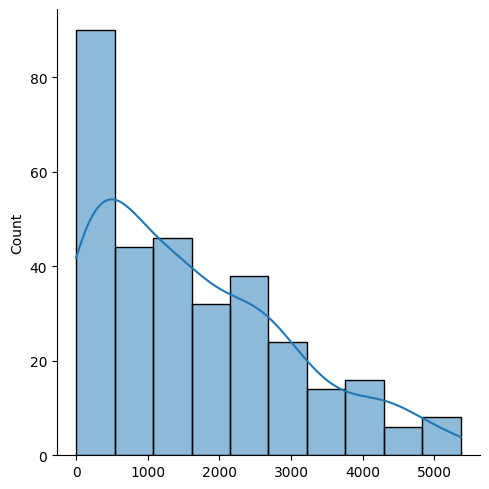

In [113]:
# density plot of the population density different for pairwise difference < 10 km
# find the indices of the points with pairwise distances < 10 km
indices = np.where(dist_matrix_suburb < 10)

# plot the density plot of the population density difference for pairwise distances < 10 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

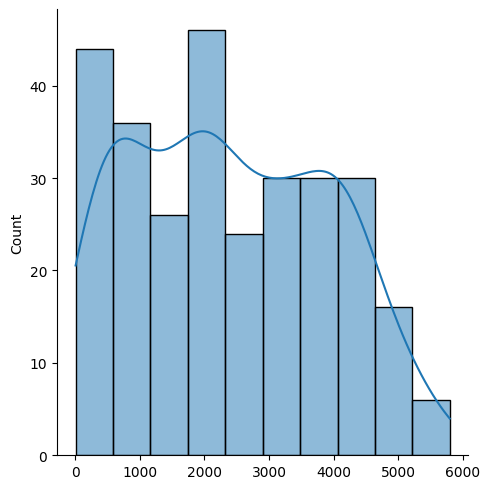

In [114]:
# density plot of the population density different for pairwise difference > 10 km < 20 km
# find the indices of the points with pairwise distances > 10 km and < 20 km
indices = np.where((dist_matrix_suburb > 10) & (dist_matrix_suburb < 20))

# plot the density plot of the population density difference for pairwise distances > 10 km and < 20 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

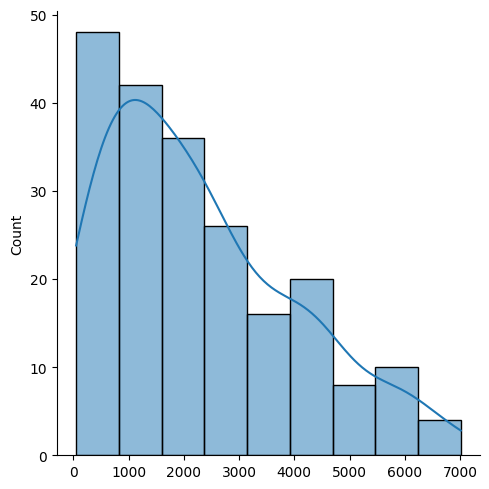

In [116]:
# density plot of the population density different for pairwise difference > 20 km < 30 km
# find the indices of the points with pairwise distances > 20 km and < 30 km
indices = np.where((dist_matrix_suburb > 20) & (dist_matrix_suburb < 30))

# plot the density plot of the population density difference for pairwise distances > 20 km and < 30 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

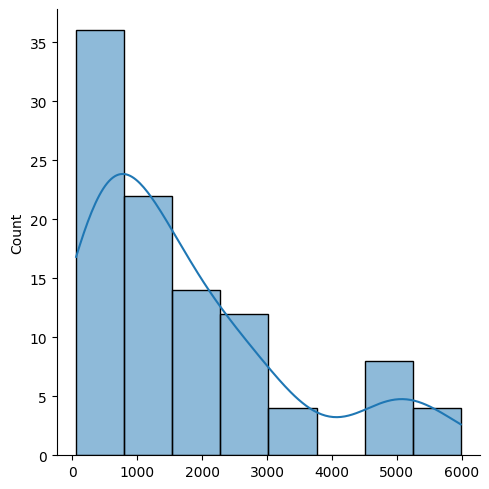

In [117]:
# density plot of the population density different for pairwise difference > 30 km < 40 km
# find the indices of the points with pairwise distances > 30 km and < 40 km
indices = np.where((dist_matrix_suburb > 30) & (dist_matrix_suburb < 40))

# plot the density plot of the population density difference for pairwise distances > 30 km and < 40 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  W.__init__(


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
Local Moran's I values: [ 0.0581991  -0.00250354 -0.         -0.         -0.00526338 -0.02477509
  0.0909079  -0.09552822  0.32204961  0.48256643  0.04995201 -0.10130695
  0.24645814  0.22857793 -0.11082179  0.7717281   0.35051837 -0.44966215
  0.00741619 -0.51730787  1.24857132  1.57187802 -0.          0.49607498
  0.93902785  0.11039107 -0.          1.05576039  1.14870179  1.02565977
  0.08338119  1.57187802  0.27832899  1.38100865]
p-values: [0.232 0.48  0.001 0.001 0.491 0.084 0.234 0.001 0.001 0.393 0.115 0.365
 0.151 0.004 0.241 0.001 0.004 0.001 0.387 0.001 0.001 0.067 0.001 0.001
 0.001 0.322 0.001 0.001 0.001 0.002 0.001 0.131 0.339 0.001]
Clusters/Outliers classification: [3 3 2 1 1 1 1 2 2 1 3 1 1 3 1 1 1 1 1]


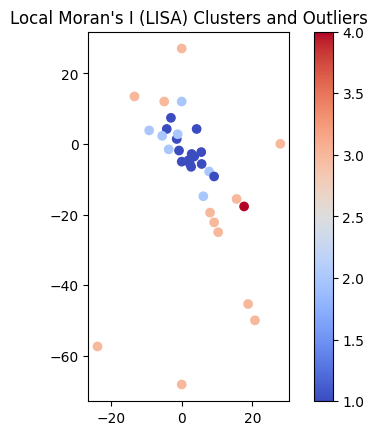

In [121]:
import numpy as np
import libpysal as lps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

population_density = df[['Population Density']].values

# Example data: values (e.g., crime rates or housing prices) for different spatial units
data = np.array(population_density[:,0].astype(float))

# Coordinates representing the locations of the spatial units
coords = np.asarray(locs)

# Create spatial weights based on distance
weights = lps.weights.DistanceBand(coords, threshold=10)
weights.transform = 'r'

# Calculate Local Moran's I
lisa = esda.Moran_Local(data, weights)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values:", lisa.Is)
print("p-values:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification:", significant_clusters)

# Visualize the LISA result
gdf = gpd.GeoDataFrame({'data': data, 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})
gdf.plot(column='lisa', cmap='coolwarm', legend=True)
plt.title("Local Moran's I (LISA) Clusters and Outliers")
plt.show()


In [122]:
# overall Moran's I
mi = esda.Moran(data, weights)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)


Moran's I: 0.4193974461571781
p-value: 0.001


In [141]:
# create a connection matrix.
W=spatial.distance.pdist(locs)
W=spatial.distance.squareform(W)
# if (i,j) belong to different clusters, W[i,j]=0
for i in range(len(W)):
	for j in range(len(W)):
		if df_clustered['Cluster'][i] != df_clustered['Cluster'][j]:
			W[i,j] = 0

# create a spatial weights object
W_dict = {}
for i in range(len(W)):
	for j in range(len(W)):
		if W[i,j] != 0:
			if i not in W_dict:
				W_dict[i] = []
			W_dict[i].append(j)


W_lps = lps.weights.W(W_dict)
W_lps

# calculate Moran's I
mi = esda.Moran(data, W_lps)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)



Moran's I: 0.6523834859661938
p-value: 0.001


C:\Users\subha\AppData\Local\Temp\ipykernel_10344\3233487294.py:20: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W_lps = lps.weights.W(W_dict)


In [127]:
cluster_weights

array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],


In [142]:
# load the feature category dictionary
import json
with open('feature_category_dict.json', 'r') as f:
	feature_category = json.load(f)

feature_category

{'2007 population': ['2007 ERP age 0-4, persons',
  '2007 ERP age 0-4, %',
  '2007 ERP age 5-9, persons',
  '2007 ERP age 5-9, %',
  '2007 ERP age 10-14, persons',
  '2007 ERP age 10-14, %',
  '2007 ERP age 15-19, persons',
  '2007 ERP age 15-19, %',
  '2007 ERP age 20-24, persons',
  '2007 ERP age 20-24, %',
  '2007 ERP age 25-44, persons',
  '2007 ERP age 25-44, %',
  '2007 ERP age 45-64, persons',
  '2007 ERP age 45-64, %',
  '2007 ERP age 65-69, persons',
  '2007 ERP age 65-69, %',
  '2007 ERP age 70-74, persons',
  '2007 ERP age 70-74, %',
  '2007 ERP age 75-79, persons',
  '2007 ERP age 75-79, %',
  '2007 ERP age 80-84, persons',
  '2007 ERP age 80-84, %',
  '2007 ERP age 85+, persons',
  '2007 ERP age 85+, %',
  '2007 ERP, total'],
 '2007-2012 population change': ['% change, 2007-2012, age 0-4',
  '% change, 2007-2012, age 5-9',
  '% change, 2007-2012, age 10-14',
  '% change, 2007-2012, age 15-19',
  '% change, 2007-2012, age 20-24',
  '% change, 2007-2012, age 25-44',
  '% cha

In [164]:
land_use_df = df[feature_category['Land Use']].copy()
land_use_df

,Commercial (km^2),Commercial (%),Industrial (km^2),Industrial (%),Residential (km^2),Residential (%),Rural (km^2),Rural (%),Other (km^2),Other (%)
0,0.110250,2.874503,0.005093,0.132784,2.894001,75.454089,0.000000,0.000000,0.826102,21.538624
1,1.013147,23.425767,0.177854,4.112305,2.198204,50.826408,0.000000,0.000000,0.935720,21.635520
2,0.782388,2.215516,1.763098,4.992626,4.486082,12.703395,1.935031,5.479494,26.347439,74.608969
3,0.228507,1.609852,0.407614,2.871681,10.370552,73.061560,0.041521,0.292517,3.146073,22.164391
4,0.123132,2.421885,0.168014,3.304669,3.661186,72.011763,0.000000,0.000000,1.131817,22.261683
5,0.412947,8.314224,0.352390,7.094986,2.122709,42.738377,0.000000,0.000000,2.078705,41.852413
6,0.140827,1.591747,0.092401,1.044400,5.724229,64.700094,0.000000,0.000000,2.889870,32.663760
7,0.435033,5.748787,0.000000,0.000000,5.350733,70.707841,0.000000,0.000000,1.781617,23.543372
8,0.129991,4.727724,0.000000,0.000000,2.309011,83.977777,0.000000,0.000000,0.310548,11.294499
9,0.021298,0.070105,0.109149,0.359280,0.006963,0.022921,7.050213,23.206867,23.192232,76.340827


In [172]:
# keep only the land use features with '%' in the name
land_use_df = land_use_df[[col for col in land_use_df.columns if not '%' in col]]
land_use_df

,Commercial (km^2),Industrial (km^2),Residential (km^2),Rural (km^2),Other (km^2)
0,0.110250,0.005093,2.894001,0.000000,0.826102
1,1.013147,0.177854,2.198204,0.000000,0.935720
2,0.782388,1.763098,4.486082,1.935031,26.347439
3,0.228507,0.407614,10.370552,0.041521,3.146073
4,0.123132,0.168014,3.661186,0.000000,1.131817
5,0.412947,0.352390,2.122709,0.000000,2.078705
6,0.140827,0.092401,5.724229,0.000000,2.889870
7,0.435033,0.000000,5.350733,0.000000,1.781617
8,0.129991,0.000000,2.309011,0.000000,0.310548
9,0.021298,0.109149,0.006963,7.050213,23.192232


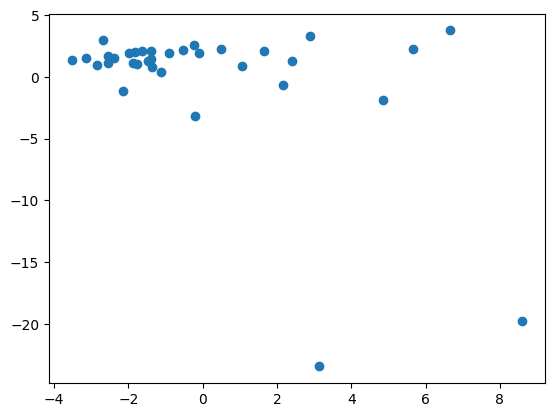

In [173]:
# do multidimensional scaling on the land use data to visualize the data in 2D
from sklearn.manifold import MDS
mds = MDS(n_components=2)
land_use_mds = mds.fit_transform(land_use_df)
plt.scatter(land_use_mds[:,0],land_use_mds[:,1])
plt.show()

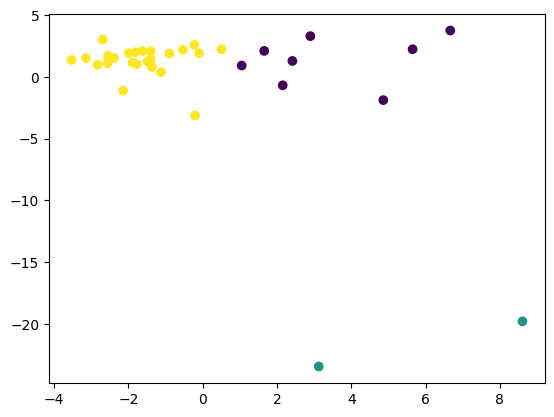

In [174]:
# do hierarchical clustering on the land use data
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(land_use_df)

# plot the clusters
plt.scatter(land_use_mds[:,0],land_use_mds[:,1],c=agg.labels_)
plt.show()


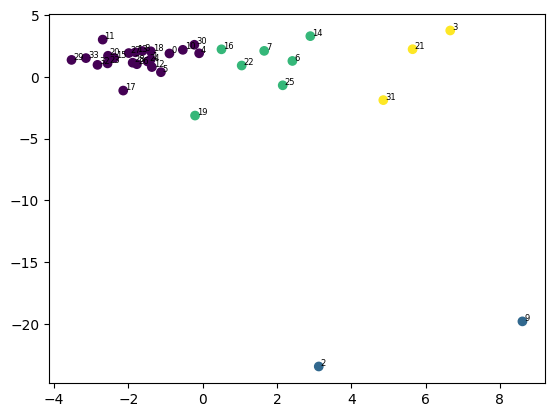

In [180]:
# do k-means clustering on the land use data
kmeans = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans.fit(land_use_df)

# plot the clusters
plt.scatter(land_use_mds[:,0],land_use_mds[:,1],c=kmeans.labels_)
# annotate each point with the corresponding point index
for i in range(len(land_use_mds)):
	plt.annotate(i, (land_use_mds[i,0]+0.05,land_use_mds[i,1]+.05), size=6)

plt.show()


In [181]:
# agreement analysis between the land use clustering and the locational clustering

kmeans_locations = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans_locations.fit(locs)

# compute NMI between the land use clustering and the locational clustering
nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_locations.labels_)
print('NMI between land use clustering and locational clustering:',nmi)


NMI between land use clustering and locational clustering: 0.25005304660951344


Moran's I for land use: 0.20319869478035815
p-value: 0.002
Local Moran's I values for land use: [ 5.04736871e-02  4.84500408e-02  2.34548532e+00  5.60777774e-02
  4.49876698e-02  2.42981417e-02  1.19798781e-03  7.80813831e-02
  1.69313284e-01  2.35453652e+00  7.92298962e-02  7.86092709e-02
  5.94715470e-02  1.67548499e-01  6.12742425e-02  5.48664878e-02
  1.21401631e-01 -6.46882320e-03  5.60900953e-02 -1.13164585e-01
  1.71937978e-01 -1.78362696e-01 -7.81523734e-02  1.38977607e-01
  1.18591721e-01 -7.17432978e-02 -3.74205740e-01  1.68628287e-01
  1.21698803e-01  1.76831288e-01  1.61223050e-01  3.66846478e-01
  7.49890753e-02  1.76536679e-01]
p-values for land use: [0.492 0.494 0.005 0.002 0.492 0.471 0.442 0.001 0.001 0.004 0.428 0.427
 0.387 0.002 0.387 0.494 0.002 0.438 0.494 0.325 0.001 0.001 0.001 0.001
 0.001 0.169 0.001 0.001 0.001 0.001 0.001 0.002 0.44  0.001]
Clusters/Outliers classification for land use: [1 1 3 3 1 3 3 3 2 2 3 3 2 3 3 3 3 1 3]


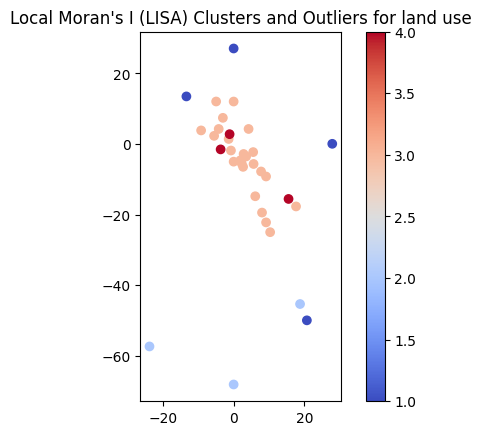

Outliers for land use: [ 2  3  9 31]
Clusters for land use: [21 22 26]
High-High clusters for land use: [ 0  1  4  5  6  7  8 10 11 12 13 14 15 16 18 20 23 24 27 28 29 30 32 33]
Low-Low clusters for land use: [17 19 25]


In [269]:
# map the land use to 1d using PCA and perform moran's I
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
land_use_pca = pca.fit_transform(land_use_df)

# use the earlier W_lps
mi = esda.Moran(land_use_pca, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)



# compute local moran's I for land use
lisa = esda.Moran_Local(land_use_pca, W_lps)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values for land use:", lisa.Is)
print("p-values for land use:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification for land use:", significant_clusters)

# Visualize the LISA result
gdf = gpd.GeoDataFrame({'data': land_use_pca.flatten(), 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})
gdf.plot(column='lisa', cmap='coolwarm', legend=True)
plt.title("Local Moran's I (LISA) Clusters and Outliers for land use")
plt.show()
# print the outliers
print('Outliers for land use:',np.where(lisa.q==1)[0])
# print the clusters
print('Clusters for land use:',np.where(lisa.q==2)[0])
# print the high-high clusters
print('High-High clusters for land use:',np.where(lisa.q==3)[0])
# print the low-low clusters
print('Low-Low clusters for land use:',np.where(lisa.q==4)[0])



In [262]:
# do t-SNE on the land use data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1)
land_use_tsne = tsne.fit_transform(land_use_df)


# use the earlier W_lps
mi = esda.Moran(land_use_tsne, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)


Moran's I for land use: -0.14797755366027607
p-value: 0.006


Moran's I for land use: 0.19261452989589525
p-value: 0.009


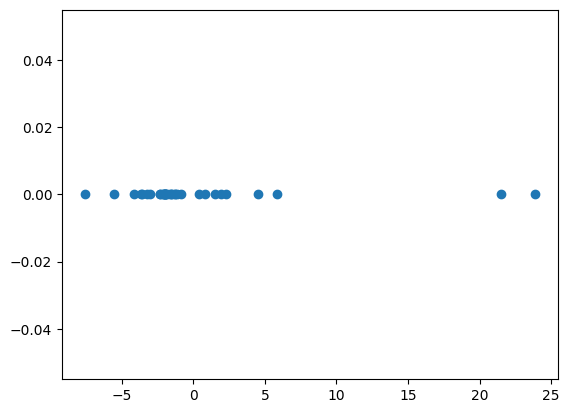

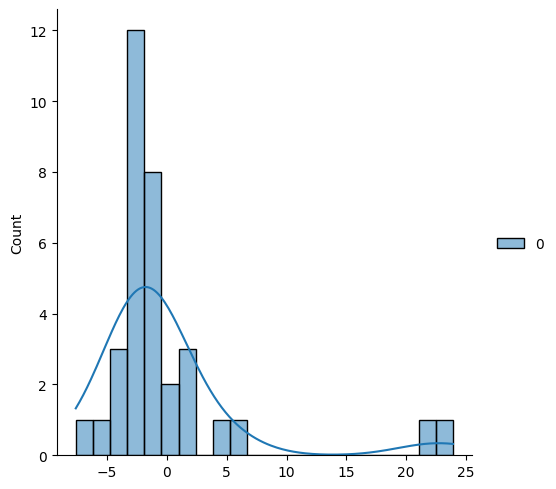

In [222]:
# do MDS to 1D on the land use data
mds = MDS(n_components=1)
land_use_mds = mds.fit_transform(land_use_df)

# use the earlier W_lps
mi = esda.Moran(land_use_mds, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)

# plot the land use data in 1D
plt.scatter(land_use_mds, np.zeros(len(land_use_mds)))
plt.show()

sns.displot(land_use_mds, kde=True)

In [224]:
land_use_df

,Commercial (km^2),Industrial (km^2),Residential (km^2),Rural (km^2),Other (km^2)
0,0.110250,0.005093,2.894001,0.000000,0.826102
1,1.013147,0.177854,2.198204,0.000000,0.935720
2,0.782388,1.763098,4.486082,1.935031,26.347439
3,0.228507,0.407614,10.370552,0.041521,3.146073
4,0.123132,0.168014,3.661186,0.000000,1.131817
5,0.412947,0.352390,2.122709,0.000000,2.078705
6,0.140827,0.092401,5.724229,0.000000,2.889870
7,0.435033,0.000000,5.350733,0.000000,1.781617
8,0.129991,0.000000,2.309011,0.000000,0.310548
9,0.021298,0.109149,0.006963,7.050213,23.192232


In [270]:
# now use 'Services' category
services_df = df[feature_category['Services']].copy()
services_df

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0
5,3,3,6,0,85,4,9,15,13,23,...,182,0,2,5,2,0,0,1,0,0
6,0,0,2,0,17,0,0,2,3,7,...,280,36,4,5,1,0,1,0,0,0
7,0,1,0,0,13,11,0,5,4,5,...,45,46,6,4,0,0,1,0,1,0
8,0,4,0,0,12,7,0,8,4,6,...,61,0,0,2,0,2,0,0,0,0
9,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [291]:
# scale the data
scaler_services = StandardScaler()
services_scaled = scaler_services.fit_transform(services_df)
services_scaled

services_df = services_scaled

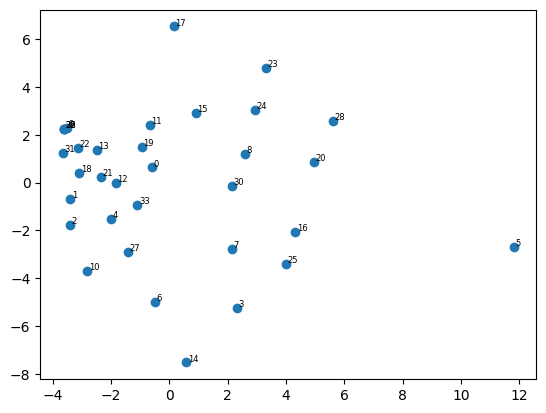

In [292]:
# MDS to 2D for services data
mds = MDS(n_components=2)
services_mds = mds.fit_transform(services_df)
plt.scatter(services_mds[:,0],services_mds[:,1])
# annotate each point with the corresponding point index
for i in range(len(services_mds)):
	plt.annotate(i, (services_mds[i,0]+0.05,services_mds[i,1]+.05), size=6)
	
plt.show()


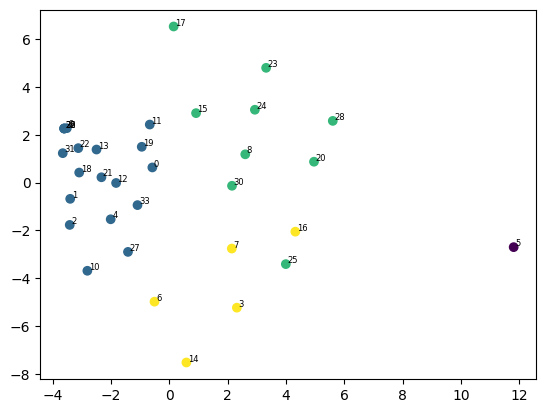

In [293]:
# do k-means clustering on the services data
kmeans = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans.fit(services_df)

# plot the clusters
plt.scatter(services_mds[:,0],services_mds[:,1],c=kmeans.labels_)

# annotate each point with the corresponding point index
for i in range(len(services_mds)):
	plt.annotate(i, (services_mds[i,0]+0.05,services_mds[i,1]+.05), size=6)

plt.show()

In [294]:
# agreement analysis between the services clustering and the locational clustering

kmeans_locations = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans_locations.fit(locs)

# compute NMI between the services clustering and the locational clustering
nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_locations.labels_)
print('NMI between services clustering and locational clustering:',nmi)


NMI between services clustering and locational clustering: 0.10052815013903102


In [295]:
# map the services to 1d using PCA and perform moran's I
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
services_pca = pca.fit_transform(services_df)

# use the earlier W_lps
mi = esda.Moran(services_pca, W_lps)
print("Moran's I for services:", mi.I)
print("p-value:", mi.p_sim)


Moran's I for services: -0.01127743197575595
p-value: 0.338


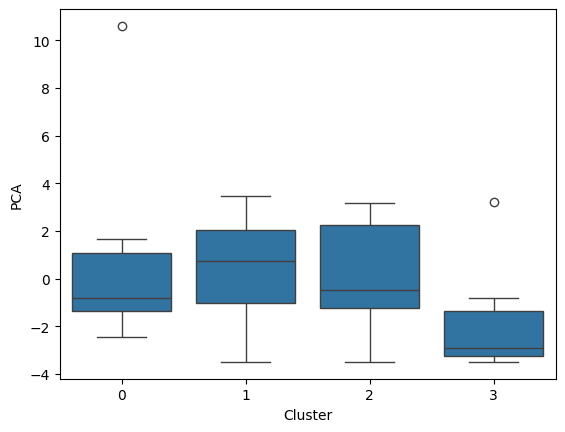

In [296]:
# do cluster-wise boxplot of the pca-transformed services data
services_pca_df = pd.DataFrame(services_pca, columns=['PCA'])
services_pca_df['Cluster'] = df_clustered['Cluster']
sns.boxplot(data=services_pca_df, x='Cluster', y='PCA')
plt.show()

In [297]:
# do anova on the pca-transformed services data
from scipy.stats import f_oneway
cluster_0 = services_pca_df[services_pca_df['Cluster']==0]['PCA']
cluster_1 = services_pca_df[services_pca_df['Cluster']==1]['PCA']
cluster_2 = services_pca_df[services_pca_df['Cluster']==2]['PCA']
cluster_3 = services_pca_df[services_pca_df['Cluster']==3]['PCA']
f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)


F_onewayResult(statistic=np.float64(1.221707121491886), pvalue=np.float64(0.3189198734969339))

Moran's I for aged care (low care): 0.02067118590541611
p-value: 0.204
SignificanceResult(statistic=np.float64(0.18667761828526253), pvalue=np.float64(0.2904562621220285))
SignificanceResult(statistic=np.float64(-0.14766339498001615), pvalue=np.float64(0.4046218994145334))


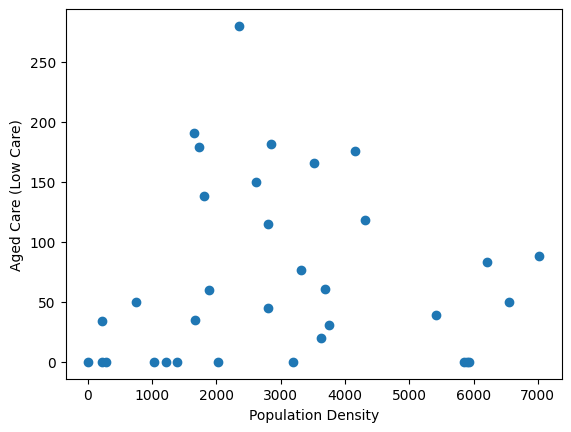

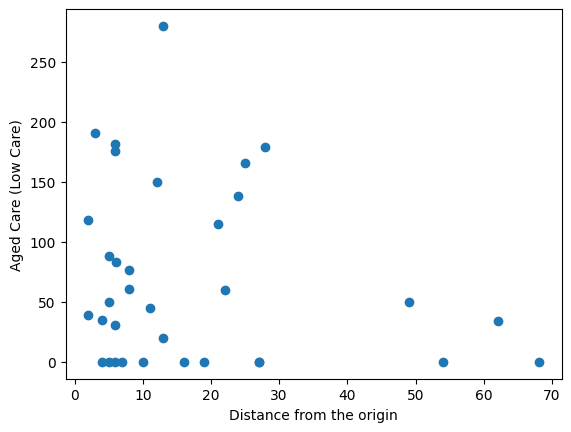

In [304]:
# check Moran's I for the 'Aged Care (Low Care)' feature
aged_care_low_care = df['Aged Care (Low Care)'].values
aged_care_low_care = aged_care_low_care.reshape(-1,1)
# use the earlier W_lps
mi = esda.Moran(aged_care_low_care, W_lps)
print("Moran's I for aged care (low care):", mi.I)
print("p-value:", mi.p_sim)

# check correlation between 'Aged Care (Low Care)' and 'Population Density'
from scipy.stats import spearmanr
print(spearmanr(df['Population Density'], df['Aged Care (Low Care)']))

# check correlation between distance from the origin and 'Aged Care (Low Care)'
print(spearmanr(np.linalg.norm(locs, axis=1), df['Aged Care (Low Care)']))

# plot for 'Aged Care (Low Care)' and 'Population Density'
plt.scatter(df['Population Density'], df['Aged Care (Low Care)'])
plt.xlabel('Population Density')
plt.ylabel('Aged Care (Low Care)')
plt.show()

# plot for 'Aged Care (Low Care)' and distance from the origin
plt.scatter(np.linalg.norm(locs, axis=1), df['Aged Care (Low Care)'])
plt.xlabel('Distance from the origin')
plt.ylabel('Aged Care (Low Care)')
plt.show()


Moran's I for public hospital separations: -0.10703196927418024
p-value: 0.141
SignificanceResult(statistic=np.float64(0.30297937356760885), pvalue=np.float64(0.08154670795083545))
SignificanceResult(statistic=np.float64(-0.10252100840336134), pvalue=np.float64(0.563967364565616))


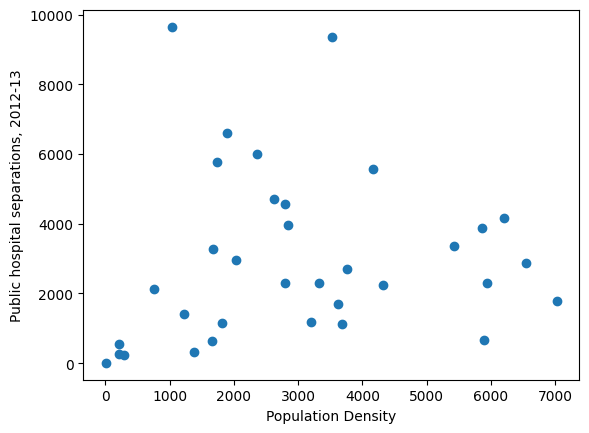

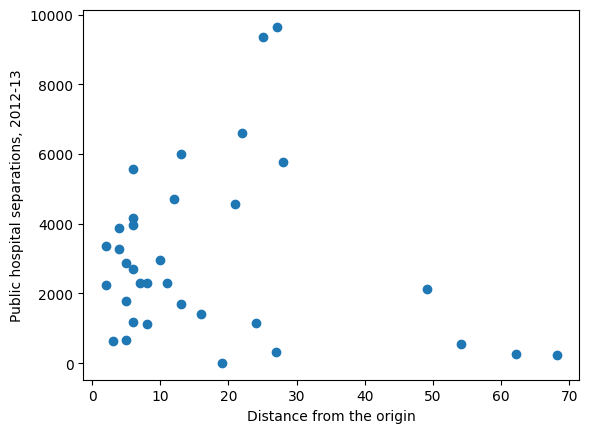

In [309]:
# check Moran's I for the 'Public hospital separations, 2012-13' feature
public_hospital_separations = df['Public hospital separations, 2012-13'].values
public_hospital_separations = public_hospital_separations.reshape(-1,1)
# use the earlier W_lps
mi = esda.Moran(public_hospital_separations, W_lps)
print("Moran's I for public hospital separations:", mi.I)
print("p-value:", mi.p_sim)

# check correlation between 'Public hospital separations, 2012-13' and 'Population Density'
from scipy.stats import spearmanr
print(spearmanr(df['Population Density'], df['Public hospital separations, 2012-13']))

# check correlation between distance from the origin and 'Public hospital separations, 2012-13'
print(spearmanr(np.linalg.norm(locs, axis=1), df['Public hospital separations, 2012-13']))

# plot for 'Public hospital separations, 2012-13' and 'Population Density'
plt.scatter(df['Population Density'], df['Public hospital separations, 2012-13'])
plt.xlabel('Population Density')
plt.ylabel('Public hospital separations, 2012-13')
plt.show()

# plot for 'Public hospital separations, 2012-13' and distance from the origin
plt.scatter(np.linalg.norm(locs, axis=1), df['Public hospital separations, 2012-13'])
plt.xlabel('Distance from the origin')
plt.ylabel('Public hospital separations, 2012-13')
plt.show()

In [311]:
# socio-demographic features
socio_demographic_features = [
    "Number of Households",
    "Average persons per household",
    "Occupied private dwellings",
    "Public Housing Dwellings",
    "Dwellings with no motor vehicle",
    "Dwellings with no internet",
    "Equivalent household income <$600/week",
    "Personal income <$400/week, persons",
    "Number of families",
    "Female-headed lone parent families",
    "Male-headed lone parent families",
    "IRSD (min)",
    "IRSD (max)",
    "IRSD (avg)",
    "Primary school students",
    "Secondary school students",
    "TAFE students",
    "University students",
    "Holds degree or higher, persons",
    "Did not complete year 12, persons",
    "Unemployed, persons",
    "Volunteers, persons",
    "Requires assistance with core activities, persons",
    "Aged 75+ and lives alone, persons",
    "Unpaid carer to person with disability, persons",
    "Unpaid carer of children, persons"
]






Number of Households
Moran's I: -0.0965982682264786
p-value: 0.213

Average persons per household
Moran's I: 0.05486067368054241
p-value: 0.04

Occupied private dwellings
Moran's I: -0.0640837978713521
p-value: 0.439

Public Housing Dwellings
Error

Dwellings with no motor vehicle
Error

Dwellings with no internet
Moran's I: -0.07714458694034788
p-value: 0.328

Equivalent household income <$600/week
Moran's I: -0.09691772603689276
p-value: 0.195

Personal income <$400/week, persons
Moran's I: -0.09270547455075463
p-value: 0.214

Number of families
Moran's I: -0.1515260582104675
p-value: 0.001

Female-headed lone parent families
Error

Male-headed lone parent families
Error

IRSD (min)
Moran's I: 0.1318283440667434
p-value: 0.042

IRSD (max)
Moran's I: 0.20795106800367377
p-value: 0.009

IRSD (avg)
Moran's I: 0.21801740048221963
p-value: 0.007

Primary school students
Moran's I: -0.12938884335739756
p-value: 0.015

Secondary school students
Moran's I: -0.11967064293128851
p-value: 0.054

In [318]:
df_sociodemo = df[socio_demographic_features].copy()
# drop rows with NaN values
df_sociodemo = df_sociodemo.dropna()
# drop columns with non-numeric values
df_sociodemo = df_sociodemo.select_dtypes(include=[np.number])
# scale the data
scaler_sociodemo = StandardScaler()
sociodemo_scaled = scaler_sociodemo.fit_transform(df_sociodemo)
df_sociodemo

,Number of Households,Average persons per household,Occupied private dwellings,Dwellings with no internet,Equivalent household income <$600/week,"Personal income <$400/week, persons",Number of families,IRSD (min),IRSD (max),IRSD (avg),Primary school students,Secondary school students,"Holds degree or higher, persons","Did not complete year 12, persons","Volunteers, persons","Unpaid carer to person with disability, persons","Unpaid carer of children, persons"
0,5546,2.433105,5634,1062,1604,3586,3447,399.590971,1104.547350,989.990716,853,624,3686,3231,1917,1121,2735
1,2994,2.734469,2908,820,1431,3315,1940,618.859618,968.902268,801.147035,582,503,993,2490,591,574,1436
2,11051,2.964257,10328,1374,3257,8792,8909,909.043625,1058.579956,990.017281,3207,2452,3189,11159,2350,2474,8187
3,10020,2.350699,9694,1941,3287,6728,6379,884.340419,1142.758266,1017.819554,1556,1265,3275,9152,3437,2220,5361
4,4552,2.769112,4403,1497,2230,5051,3275,843.188699,1003.111777,901.678423,961,746,1326,4771,821,1249,2243
5,5288,2.495461,5606,1048,1981,4453,2798,755.707483,1059.140058,938.998830,474,430,3426,2935,1516,930,2017
6,7566,2.598731,7414,2103,3182,6933,4937,708.838704,1037.438556,930.862202,1192,1045,2461,7050,1582,1849,3521
7,7666,2.620271,7569,997,1800,5563,4995,998.481428,1167.399105,1090.625034,1711,1310,6573,3725,3566,1881,4543
8,3739,2.542926,3733,423,611,2078,2414,1058.938656,1147.312005,1103.480211,786,584,3559,1473,1795,949,2185
9,19,7.368421,32,6,7,24,16,1069.889461,1069.889461,1069.889461,7,10,19,34,17,13,32


In [328]:
# check Moran's I for the socio-demographic features
# use the earlier W_lps
tracker_p_values_sociodemo = []
for i in range(sociodemo_scaled.shape[1]):
	mi = esda.Moran(sociodemo_scaled[:,i], W_lps)
	print(f"Moran's I for socio-demographic feature {i}:", mi.I)
	print("p-value:", mi.p_sim)
	tracker_p_values_sociodemo.append(mi.p_sim)
	

Moran's I for socio-demographic feature 0: -0.09659826822647861
p-value: 0.209
Moran's I for socio-demographic feature 1: 0.054860673680542434
p-value: 0.033
Moran's I for socio-demographic feature 2: -0.06408379787135211
p-value: 0.403
Moran's I for socio-demographic feature 3: -0.07714458694034788
p-value: 0.346
Moran's I for socio-demographic feature 4: -0.09691772603689278
p-value: 0.161
Moran's I for socio-demographic feature 5: -0.09270547455075463
p-value: 0.23
Moran's I for socio-demographic feature 6: -0.1515260582104675
p-value: 0.001
Moran's I for socio-demographic feature 7: 0.13182834406674337
p-value: 0.03
Moran's I for socio-demographic feature 8: 0.20795106800367377
p-value: 0.005
Moran's I for socio-demographic feature 9: 0.2180174004822196
p-value: 0.013
Moran's I for socio-demographic feature 10: -0.12938884335739753
p-value: 0.019
Moran's I for socio-demographic feature 11: -0.1196706429312885
p-value: 0.062
Moran's I for socio-demographic feature 12: 0.362908210909

In [329]:
# check which features have significant p-values
significant_features_sociodemo = np.where(np.array(tracker_p_values_sociodemo) < 0.05)[0]
for i in significant_features_sociodemo:
	print(f'Significant feature {i}: {socio_demographic_features[i]}')

Significant feature 1: Average persons per household
Significant feature 6: Equivalent household income <$600/week
Significant feature 7: Personal income <$400/week, persons
Significant feature 8: Number of families
Significant feature 9: Female-headed lone parent families
Significant feature 10: Male-headed lone parent families
Significant feature 12: IRSD (max)
Significant feature 15: Secondary school students
Significant feature 16: TAFE students


In [383]:
diversity_features =[
    "Travel time to nearest public hospital with emergency department",
    "Distance to nearest public hospital with emergency department",
    "Presentations to emergency departments due to injury",
    "Presentations to emergency departments due to injury, %",
    "Category 4 & 5 emergency department presentations",
    "Category 4 & 5 emergency department presentations, %"
]



df_diversity = df[diversity_features].copy()
# drop rows with NaN values
df_diversity = df_diversity.dropna()
# drop columns with non-numeric values
df_diversity = df_diversity.select_dtypes(include=[np.number])
# scale the data
scaler_diversity = StandardScaler()
diversity_scaled = scaler_diversity.fit_transform(df_diversity)
df_diversity


,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032
1,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428
2,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988
3,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026
4,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315
5,7.261573,5.514839,878.066191,20.647263,2719.917638,63.957428
6,13.252894,12.722850,1063.320056,17.909865,3036.292274,51.141315
7,8.746589,8.006951,324.067452,19.596542,847.427721,51.244433
8,7.386301,5.312177,155.249109,19.596542,405.972268,51.244433
9,19.921651,22.608084,8.837967,20.618005,22.056327,51.454988


In [384]:
# select the rows present in the locational data and the diversity data
df_diversity_with_location = df.loc[df_diversity.index]
df_diversity_with_location

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947
5,Footscray,Northern and Western Metropolitan,4,B3,6km WNW of Melbourne,2848.743284,9.394512,7.034739,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,7.261573,5.514839,878.066191,20.647263,2719.917638,63.957428,-37.793136,144.900092,-5.528560,2.302152
6,Glenroy,Northern and Western Metropolitan,4,B1,13km NNW of Melbourne,2352.122818,15.982083,14.687751,Moreland (C),Inner North West Primary Care Partnership,...,13.252894,12.722850,1063.320056,17.909865,3036.292274,51.141315,-37.705617,144.906612,-4.955834,12.033903
7,Malvern East,Southern Metropolitan,1,D2,11km SE of Melbourne,2795.946571,13.811856,13.962712,Stonnington (C),Inner South East Partnership in Community & He...,...,8.746589,8.006951,324.067452,19.596542,847.427721,51.244433,-37.883885,145.051446,7.767033,-7.788594
8,Malvern,Southern Metropolitan,1,C2,8km SE of Melbourne,3686.421646,11.983264,11.583241,Stonnington (C),Inner South East Partnership in Community & He...,...,7.386301,5.312177,155.249109,19.596542,405.972268,51.244433,-37.864788,145.027315,5.647293,-5.665173
9,Melbourne Airport,Northern and Western Metropolitan,1,E4,19km NW of Melbourne,5.200815,22.650840,24.572985,Hume (C),Hume-Whittlesea Primary Care Partnership,...,19.921651,22.608084,8.837967,20.618005,22.056327,51.454988,-37.692696,144.810700,-13.381261,13.470574


In [385]:
# create a connection matrix. A new connection matrix is required since the diversity data has some rows removed
diversity_loc_tuple=np.array([np.asarray([i,j]) for (i,j) in zip(df_diversity_with_location['cart_x'],df_diversity_with_location['cart_y'])])
W_diversity=spatial.distance.pdist(diversity_loc_tuple)
W_diversity=spatial.distance.squareform(W_diversity)
# if (i,j) belong to different clusters, W[i,j]=0
for i in range(len(W_diversity)):
	for j in range(len(W_diversity)):
		if df_clustered['Cluster'][i] != df_clustered['Cluster'][j]:
			W_diversity[i,j] = 0

# create a spatial weights object
W_dict_diversity = {}
for i in range(len(W_diversity)):
	for j in range(len(W_diversity)):
		if W_diversity[i,j] != 0:
			if i not in W_dict_diversity:
				W_dict_diversity[i] = []
			W_dict_diversity[i].append(j)

W_lps_diversity = lps.weights.W(W_dict_diversity)
W_lps_diversity


C:\Users\subha\AppData\Local\Temp\ipykernel_10344\2501672380.py:20: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W_lps_diversity = lps.weights.W(W_dict_diversity)


In [386]:
# check Moran's I for the diversity features
# use the earlier W_lps_diversity
tracker_p_values_diversity = []
for i in range(diversity_scaled.shape[1]):
	mi = esda.Moran(diversity_scaled[:,i], W_lps_diversity, permutations=9999)
	print(f"Moran's I for diversity feature {i}:", mi.I)
	print("p-value:", mi.p_sim)
	tracker_p_values_diversity.append(mi.p_sim)

# check which features have significant p-values
significant_features_diversity = np.where(np.array(tracker_p_values_diversity) < 0.05)[0]
for i in significant_features_diversity:
	print(f'Significant feature {i}: {diversity_features[i]}')


Moran's I for diversity feature 0: 0.31505170943675015
p-value: 0.0014
Moran's I for diversity feature 1: 0.40107776410888485
p-value: 0.0003
Moran's I for diversity feature 2: -0.08483963927197372
p-value: 0.2672
Moran's I for diversity feature 3: 0.6331736541776758
p-value: 0.0001
Moran's I for diversity feature 4: -0.12005269565605617
p-value: 0.0599
Moran's I for diversity feature 5: 0.4882241292462318
p-value: 0.0001
Significant feature 0: Travel time to nearest public hospital with emergency department
Significant feature 1: Distance to nearest public hospital with emergency department
Significant feature 3: Presentations to emergency departments due to injury, %
Significant feature 5: Category 4 & 5 emergency department presentations, %


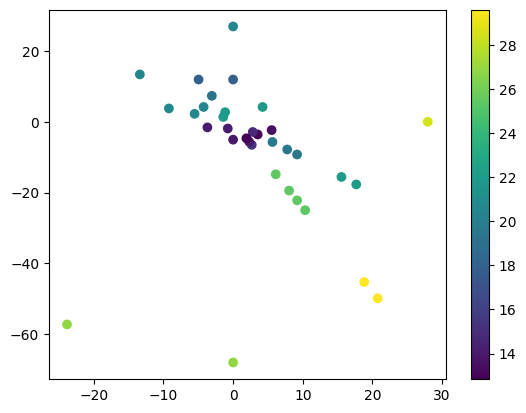

In [389]:
# plot the 'Presentations to emergency departments due to injury' feature over the map
plt.scatter(df_diversity_with_location['cart_x'],df_diversity_with_location['cart_y'],c=df_diversity_with_location['Presentations to emergency departments due to injury, %'])
plt.colorbar()
plt.show()

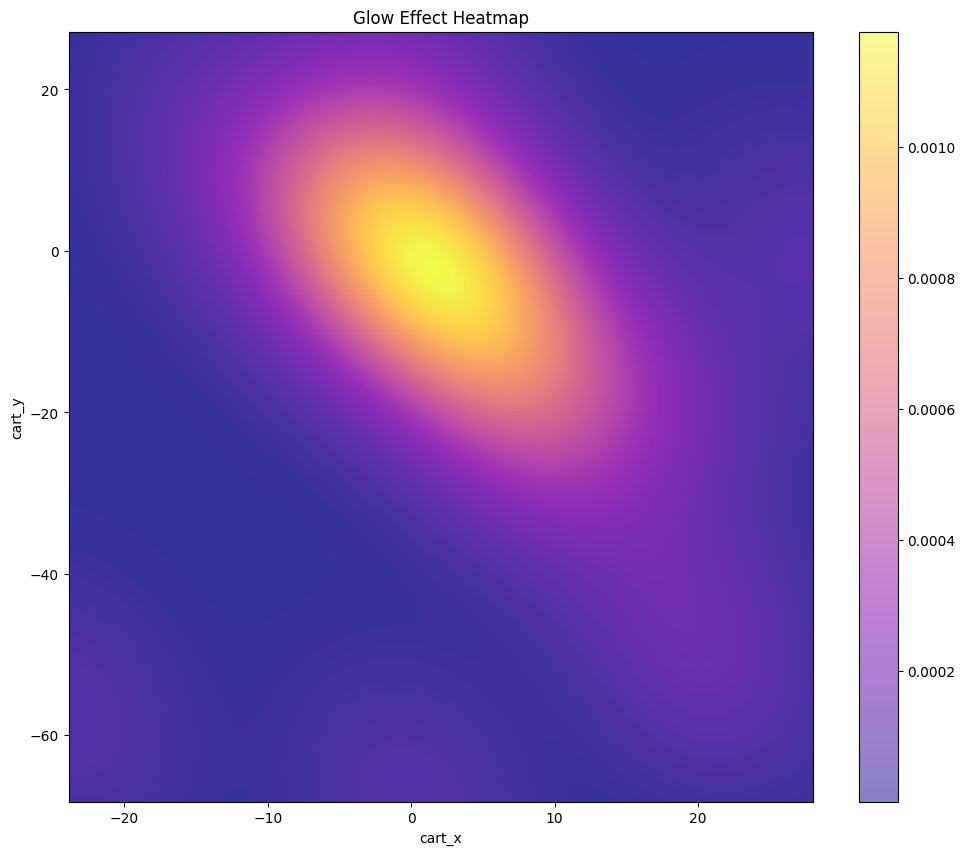

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming df_diversity_with_location is already defined and contains 'cart_x' and 'cart_y'
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Perform Kernel Density Estimation
k = gaussian_kde(np.vstack([x, y]))

# Define a very dense grid for higher resolution
grid_size = 500  # Adjust for resolution
xi, yi = np.mgrid[x.min():x.max():grid_size*1j, y.min():y.max():grid_size*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create a glow-like heatmap
plt.figure(figsize=(12, 10))

# Plot several layers with different alpha values for a glow effect
for alpha in np.linspace(0.05, 0.5, 5):  # Adjust alpha values and the number of layers
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='plasma', alpha=alpha)

# Add a colorbar and labels
plt.colorbar()
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Glow Effect Heatmap')
plt.show()


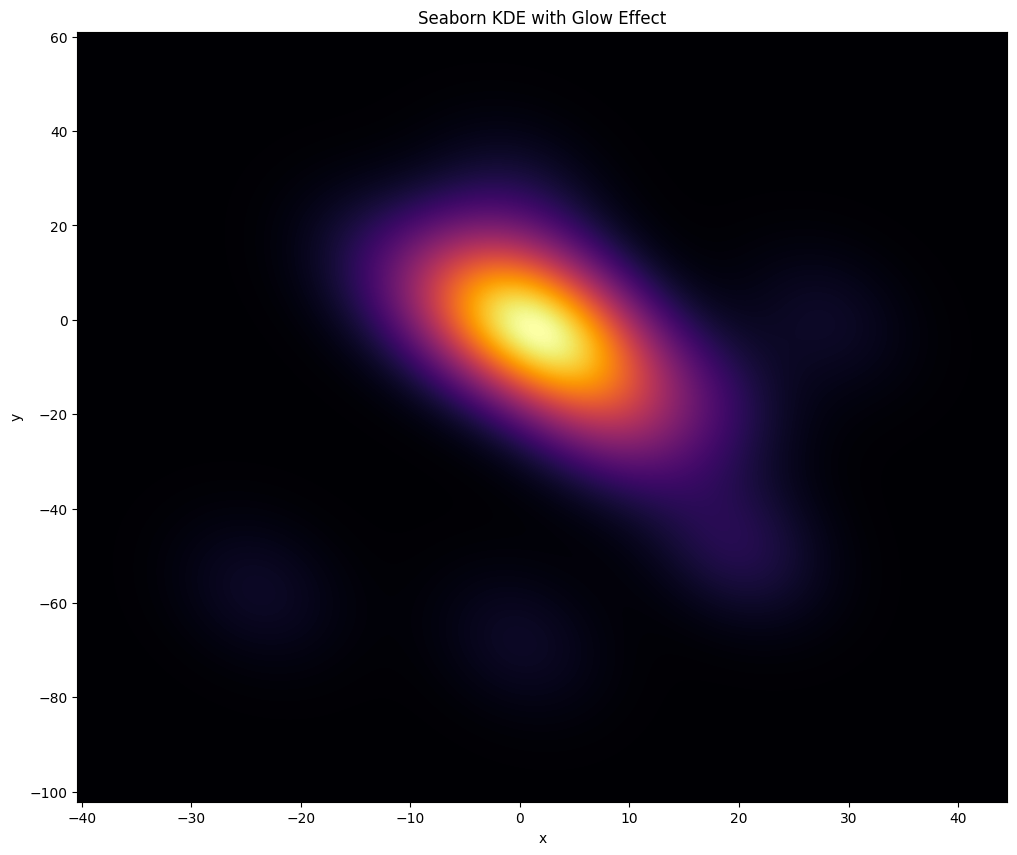

In [399]:
import seaborn as sns

# Create a DataFrame for the KDE plot
import pandas as pd
df_kde = pd.DataFrame({'x': x, 'y': y})

# Use seaborn's kdeplot for a smoother look
plt.figure(figsize=(12, 10))
sns.kdeplot(
    data=df_kde, x='x', y='y', 
    cmap='inferno',  # Choose a glowing colormap
    fill=True, 
    thresh=0,  # Show even low-density areas
    levels=1000  # Increase levels for more detail
)
plt.title('Seaborn KDE with Glow Effect')
plt.show()


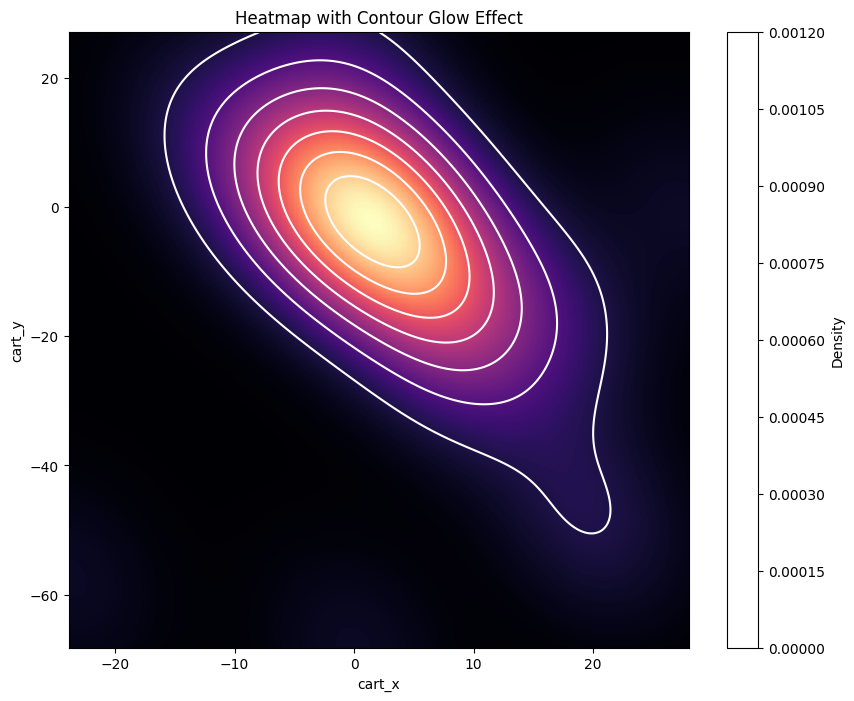

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data for x and y (replace with your actual data)
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Perform Kernel Density Estimation
k = gaussian_kde(np.vstack([x, y]))

# Define a very dense grid for higher resolution
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create the heatmap background with contours for a glowing effect
plt.figure(figsize=(10, 8))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='magma')
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, linewidths=1.5, colors='white')  # Add contour lines
plt.colorbar(label='Density')
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Heatmap with Contour Glow Effect')
plt.show()


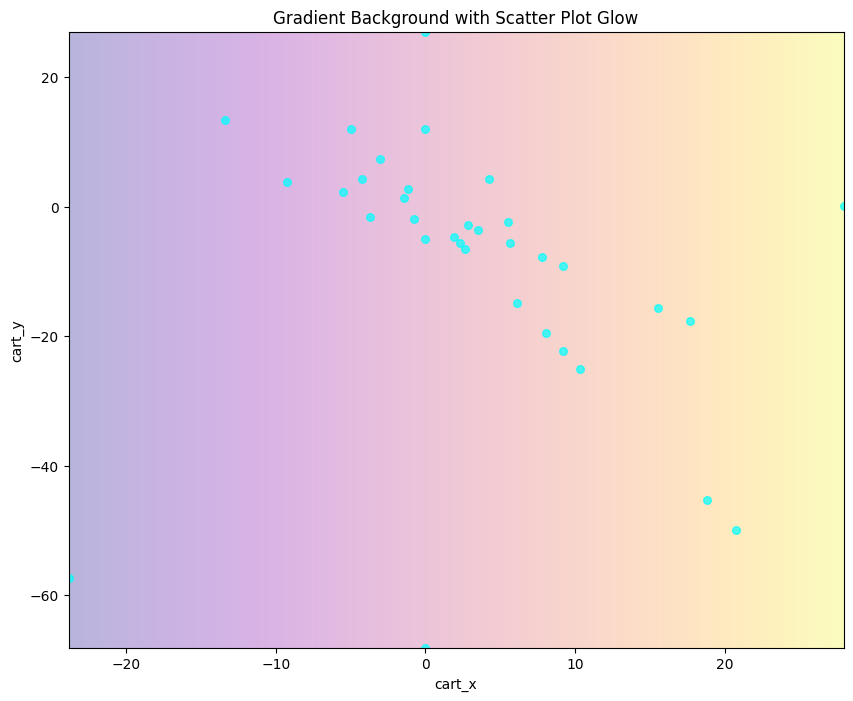

In [405]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for x and y (replace with your actual data)
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Create the figure
plt.figure(figsize=(10, 8))

# Create a gradient background
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', extent=[x.min(), x.max(), y.min(), y.max()],
           cmap='plasma', alpha=0.3)

# Scatter the points on top of the gradient
plt.scatter(x, y, s=30, alpha=0.7, color='cyan')

# Add labels and title
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Gradient Background with Scatter Plot Glow')
plt.grid(False)
plt.show()
